## Exploring the corpus using Spacy

First, let's load in the dataset we've cleaned up and the `sentencenlp.pkl` we generated via the XYZ script.
Note that that script takes approximately overnight to run on desktop.

In [1]:
import numpy as np
import pandas as pd
# silence annoying warning
pd.options.mode.chained_assignment = None  # default='warn'
#import spacy
#from spacy.matcher import PhraseMatcher
#from spacy.tokens import Span
#from spacytextblob.spacytextblob import SpacyTextBlob
from functs import obesitylist, convert_month, explore_tokens
import seaborn as sns
import matplotlib
from matplotlib import style
from pathlib import Path

# load data and obesity names
corpusdf = pd.read_pickle("../200_data_clean/corpusdf.pickle")
# drop unneccessary columns
corpusdf = corpusdf.drop(['filename', 'encoding', 'confidence', 'fullpath','year', 'numeric_month'], axis=1)
# and make a key: date_source_fourdigitcode
sentencenlp = pd.read_pickle("sentencenlp.pkl")
obesitynames = obesitylist()

corpusdf = corpusdf.assign(sentencenlp=sentencenlp)
corpusdf = corpusdf.assign(articlesummary=corpusdf['sentencenlp'].map(lambda x: explore_tokens(x, obesitynames=obesitynames)))


In [2]:
lst_col = 'articlesummary'
# pivot article summary longer
corpusdf = pd.DataFrame({col:np.repeat(corpusdf[col].values, corpusdf[lst_col].str.len())for col in corpusdf.columns.difference([lst_col]) }).assign(**{lst_col:np.concatenate(corpusdf[lst_col].values)})[corpusdf.columns.tolist()]
# now each row has a dict with 7 keys
corpusdf = pd.concat([corpusdf.drop([lst_col], axis=1), corpusdf[lst_col].apply(pd.Series)], axis=1)
# and now that dict has been split into 7 columns

# clean up capitalisation
corpusdf["text"] = corpusdf["text"].str.lower()
corpusdf["left"] = corpusdf["left"].str.lower()
corpusdf["right"] = corpusdf["right"].str.lower()
corpusdf.columns
corpusdf["headword"] = corpusdf["head"].apply(lambda x: x.orth_)
corpusdf["headword"] = corpusdf["headword"].str.lower()
corpusdf.drop('head', inplace=True, axis=1)
# write out to csv file
corpusdf.drop(['body', 'metadata', 'sentencenlp'], axis=1).to_csv("../300_data_processed/pos_annotated_with_spacy.csv")

Now that we've created the dataset, let's explore.

What is the overall structure of tags, grouped by words of interest?
- JJ: adjective
- NN: noun, singular or mass
- NNP: noun, proper singular
- NNS: noun, plural
- RB: adverb
- VB: verb, base form
- VBP: verb, non-3rd person singular present
- XX: unknown

In [3]:
corpusdf.groupby(['text']).tag.value_counts().unstack().fillna(0)

tag,JJ,NN,NNP,NNS,RB,VB,VBP,XX
text,,,,,,,,
obese,13769.0,4960.0,0.0,278.0,7.0,29.0,11.0,2.0
obesity,887.0,32549.0,1.0,0.0,0.0,1.0,0.0,0.0
obesogenic,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
obesogenics,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
obesogens,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0


What is the overall structure of dependency attributes, grouped by words of interest?


In [4]:
# from https://github.com/explosion/spaCy/blob/master/spacy/glossary.py
spacy_explanation = pd.DataFrame.from_dict({"acl": "clausal modifier of noun (adjectival clause)",
                                              "acomp": "adjectival complement",
                                              "advcl": "adverbial clause modifier",
                                              "advmod": "adverbial modifier",
                                              "agent": "agent",
                                              "amod": "adjectival modifier",
                                              "appos": "appositional modifier",
                                              "attr": "attribute",
                                              "aux": "auxiliary",
                                              "auxpass": "auxiliary (passive)",
                                              "case": "case marking",
                                              "cc": "coordinating conjunction",
                                              "ccomp": "clausal complement",
                                              "clf": "classifier",
                                              "complm": "complementizer",
                                              "compound": "compound",
                                              "conj": "conjunct",
                                              "cop": "copula",
                                              "csubj": "clausal subject",
                                              "csubjpass": "clausal subject (passive)",
                                              "dative": "dative",
                                              "dep": "unclassified dependent",
                                              "det": "determiner",
                                              "discourse": "discourse element",
                                              "dislocated": "dislocated elements",
                                              "dobj": "direct object",
                                              "expl": "expletive",
                                              "fixed": "fixed multiword expression",
                                              "flat": "flat multiword expression",
                                              "goeswith": "goes with",
                                              "hmod": "modifier in hyphenation",
                                              "hyph": "hyphen",
                                              "infmod": "infinitival modifier",
                                              "intj": "interjection",
                                              "iobj": "indirect object",
                                              "list": "list",
                                              "mark": "marker",
                                              "meta": "meta modifier",
                                              "neg": "negation modifier",
                                              "nmod": "modifier of nominal",
                                              "nn": "noun compound modifier",
                                              "npadvmod": "noun phrase as adverbial modifier",
                                              "nsubj": "nominal subject",
                                              "nsubjpass": "nominal subject (passive)",
                                              "nounmod": "modifier of nominal",
                                              "npmod": "noun phrase as adverbial modifier",
                                              "num": "number modifier",
                                              "number": "number compound modifier",
                                              "nummod": "numeric modifier",
                                              "oprd": "object predicate",
                                              "obj": "object",
                                              "obl": "oblique nominal",
                                              "orphan": "orphan",
                                              "parataxis": "parataxis",
                                              "partmod": "participal modifier",
                                              "pcomp": "complement of preposition",
                                              "pobj": "object of preposition",
                                              "poss": "possession modifier",
                                              "possessive": "possessive modifier",
                                              "preconj": "pre-correlative conjunction",
                                              "prep": "prepositional modifier",
                                              "prt": "particle",
                                              "punct": "punctuation",
                                              "quantmod": "modifier of quantifier",
                                              "rcmod": "relative clause modifier",
                                              "relcl": "relative clause modifier",
                                              "reparandum": "overridden disfluency",
                                              "root": "root",
                                              "vocative": "vocative",
                                              "xcomp": "open clausal complement"},
                                           orient='index',
                                           columns= ['explanation'])
spacy_explanation['dep'] = spacy_explanation.index

tmpdf = corpusdf.groupby(['text']).dep.value_counts().unstack().fillna(0).transpose()
tmpdf['text'] = tmpdf.index
mergeddf = pd.merge(tmpdf, spacy_explanation, how='left',left_on='text', right_on='dep')
collist = mergeddf.columns.to_list()[-3:-1] +  mergeddf.columns.to_list()[0:-3]
display(mergeddf.reindex(columns=collist))
# clean up workspace
[globals().pop(x, None) for x in ['collist', 'tmpdf', 'mergeddf']];


,text,explanation,obese,obesity,obesogenic,obesogenics,obesogens
0,ROOT,NaN,40.0,40.0,0.0,0.0,0.0
1,acomp,adjectival complement,992.0,0.0,5.0,0.0,0.0
2,advcl,adverbial clause modifier,40.0,1.0,0.0,0.0,0.0
3,advmod,adverbial modifier,3.0,0.0,0.0,0.0,0.0
4,amod,adjectival modifier,6006.0,885.0,90.0,0.0,0.0
5,appos,appositional modifier,116.0,223.0,0.0,0.0,0.0
6,attr,attribute,3581.0,217.0,0.0,0.0,0.0
7,ccomp,clausal complement,77.0,2.0,0.0,0.0,0.0
8,compound,compound,36.0,8632.0,0.0,0.0,0.0
9,conj,conjunct,6161.0,4391.0,1.0,0.0,2.0


### How is obese modified?
Investigate looking at situations where the dep is a `amod` and obese is the `text` - what is the `left` word?

In [5]:
obese_amod = corpusdf[(corpusdf['dep']=='amod') & (corpusdf['text']=='obese')]

Investigate looking at situations where the dep is a `amod` and obese is the `text` - what is the `left` word?

In [6]:
obese_amod.left.value_counts().head(20)

obese           4813
morbidly         465
most             155
severely         152
very              79
extremely         45
increasingly      29
more              25
formerly          16
super             15
seriously         12
grossly           10
clinically        10
chronically        9
moderately         8
second             8
enormously         6
already            6
dangerously        5
overweight         5
Name: left, dtype: int64

We can group these by year and/or publication:

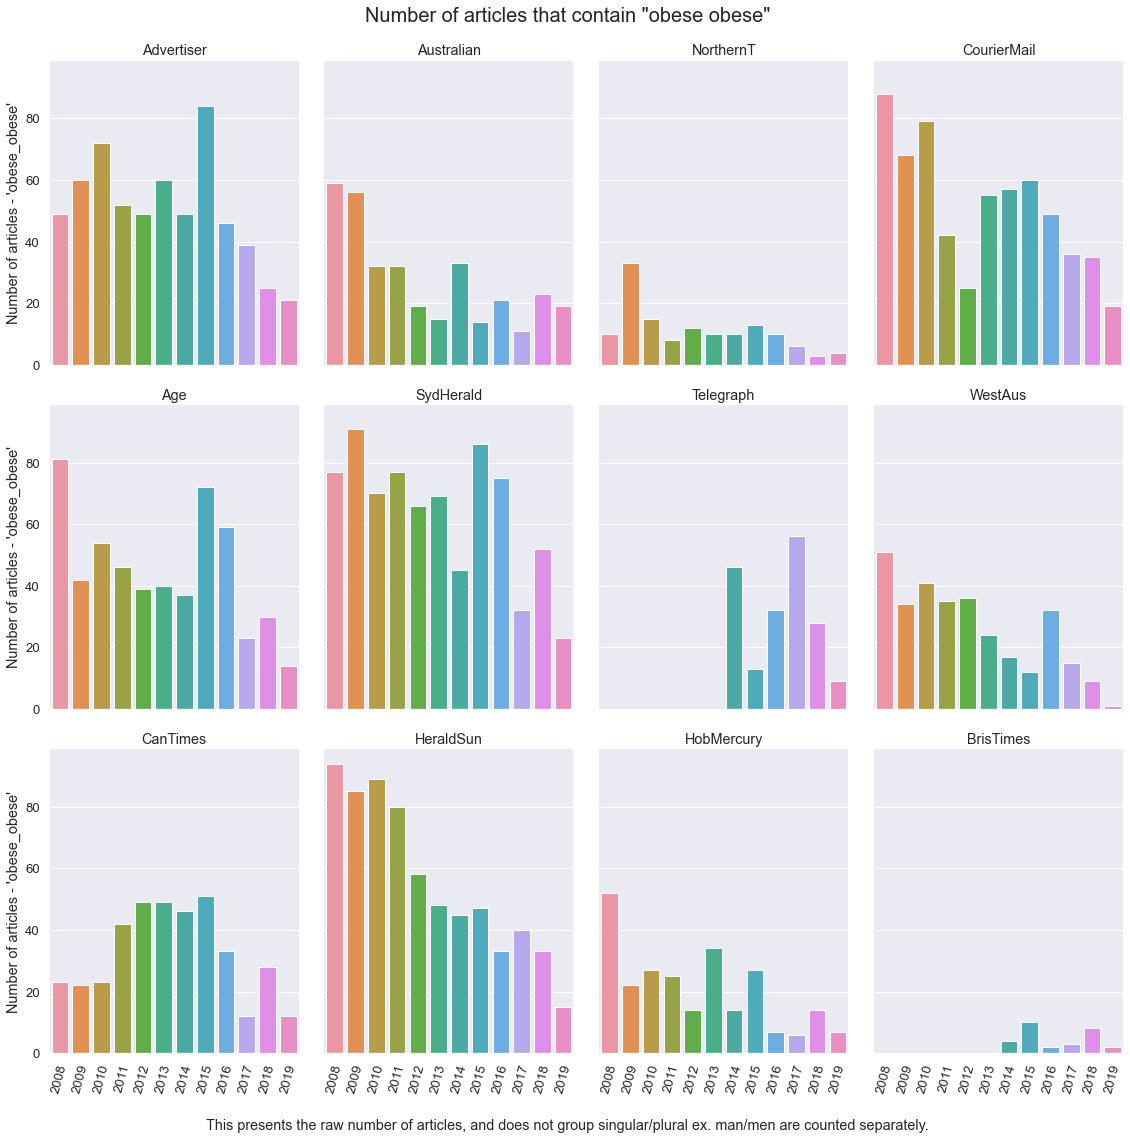

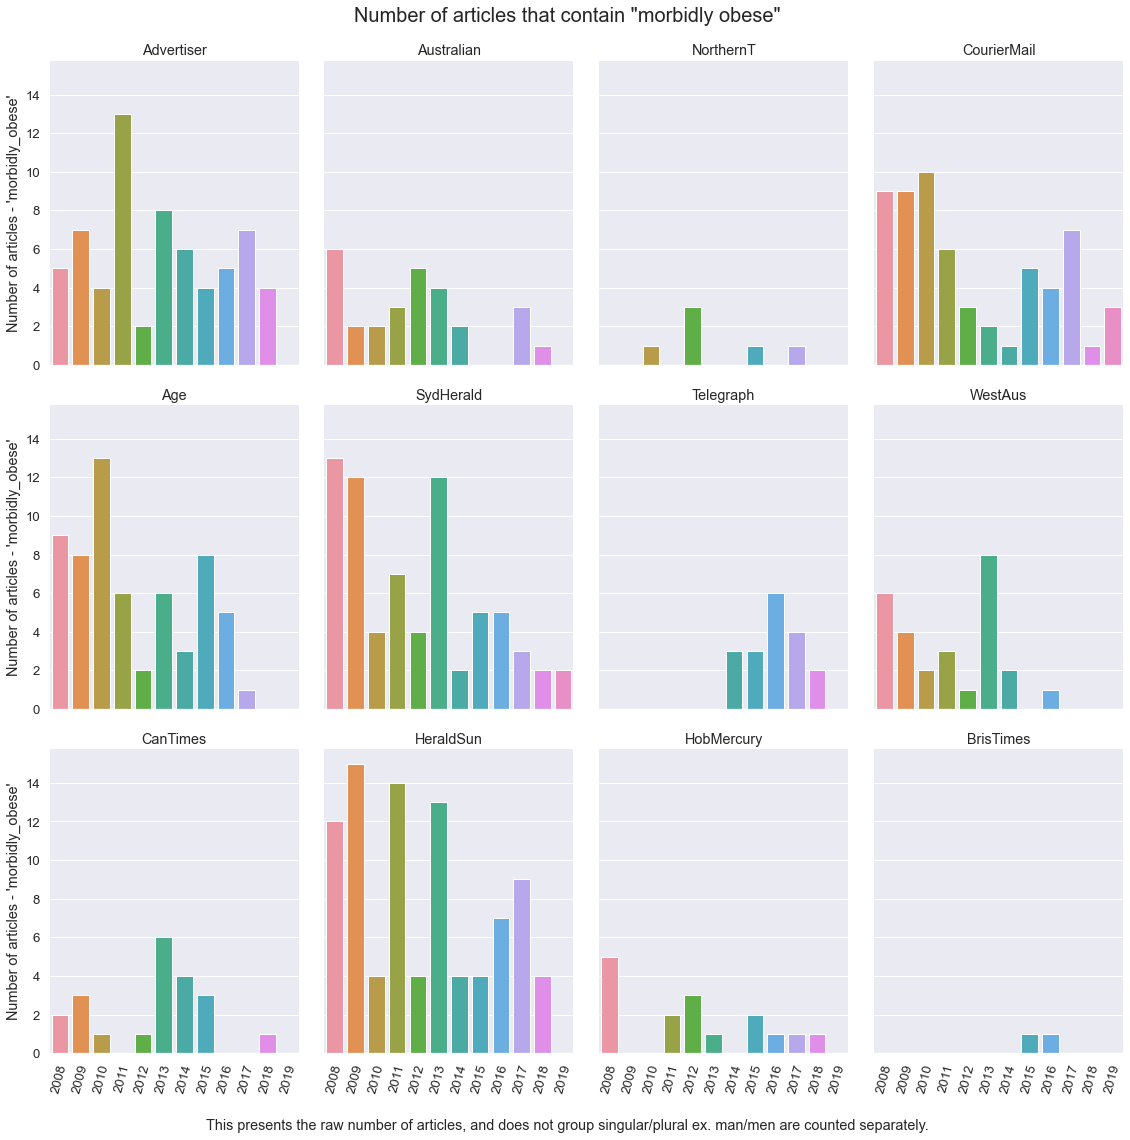

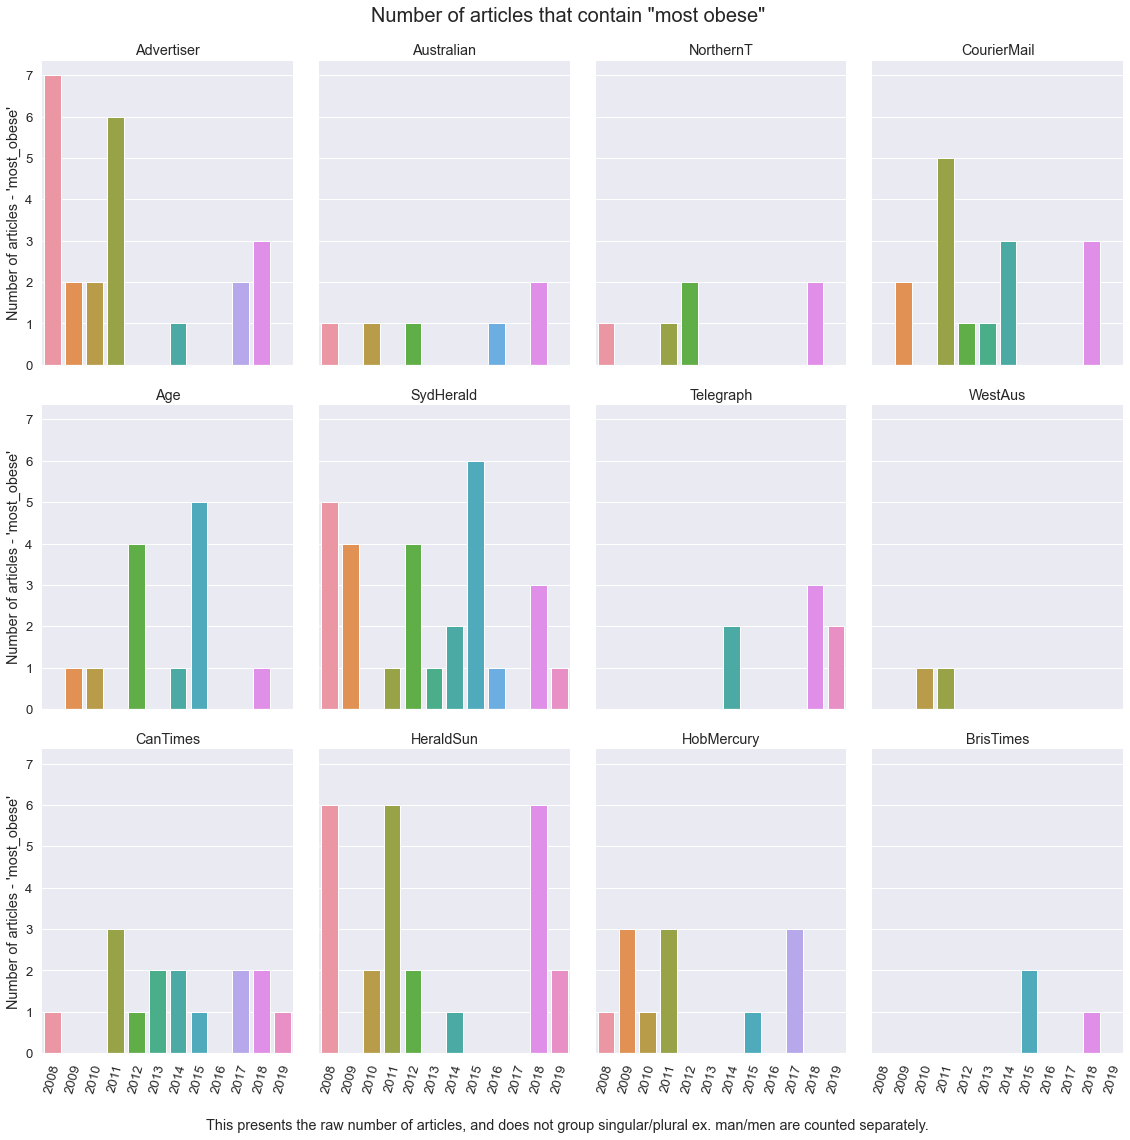

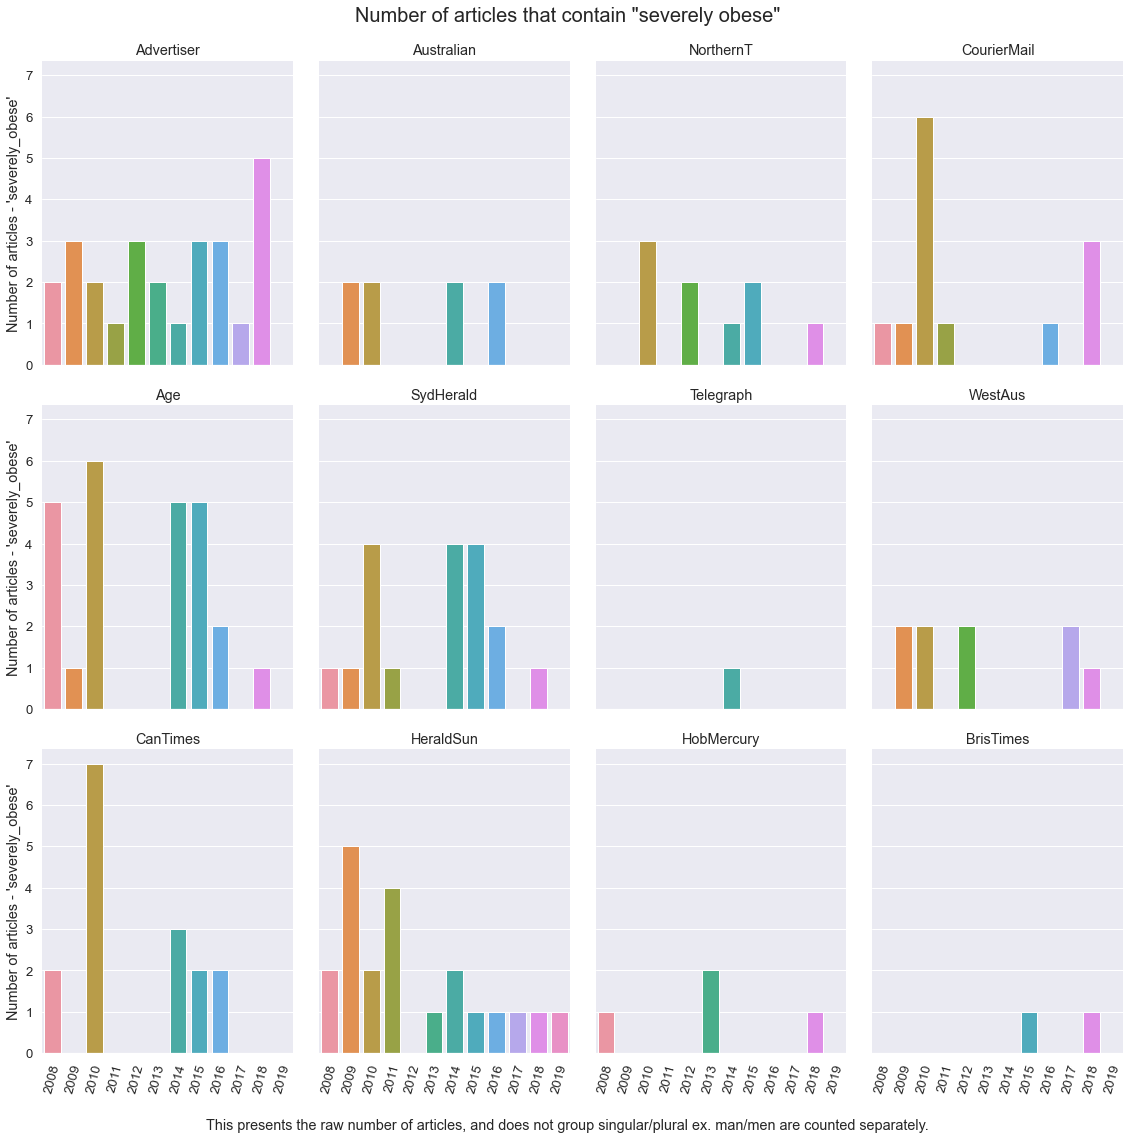

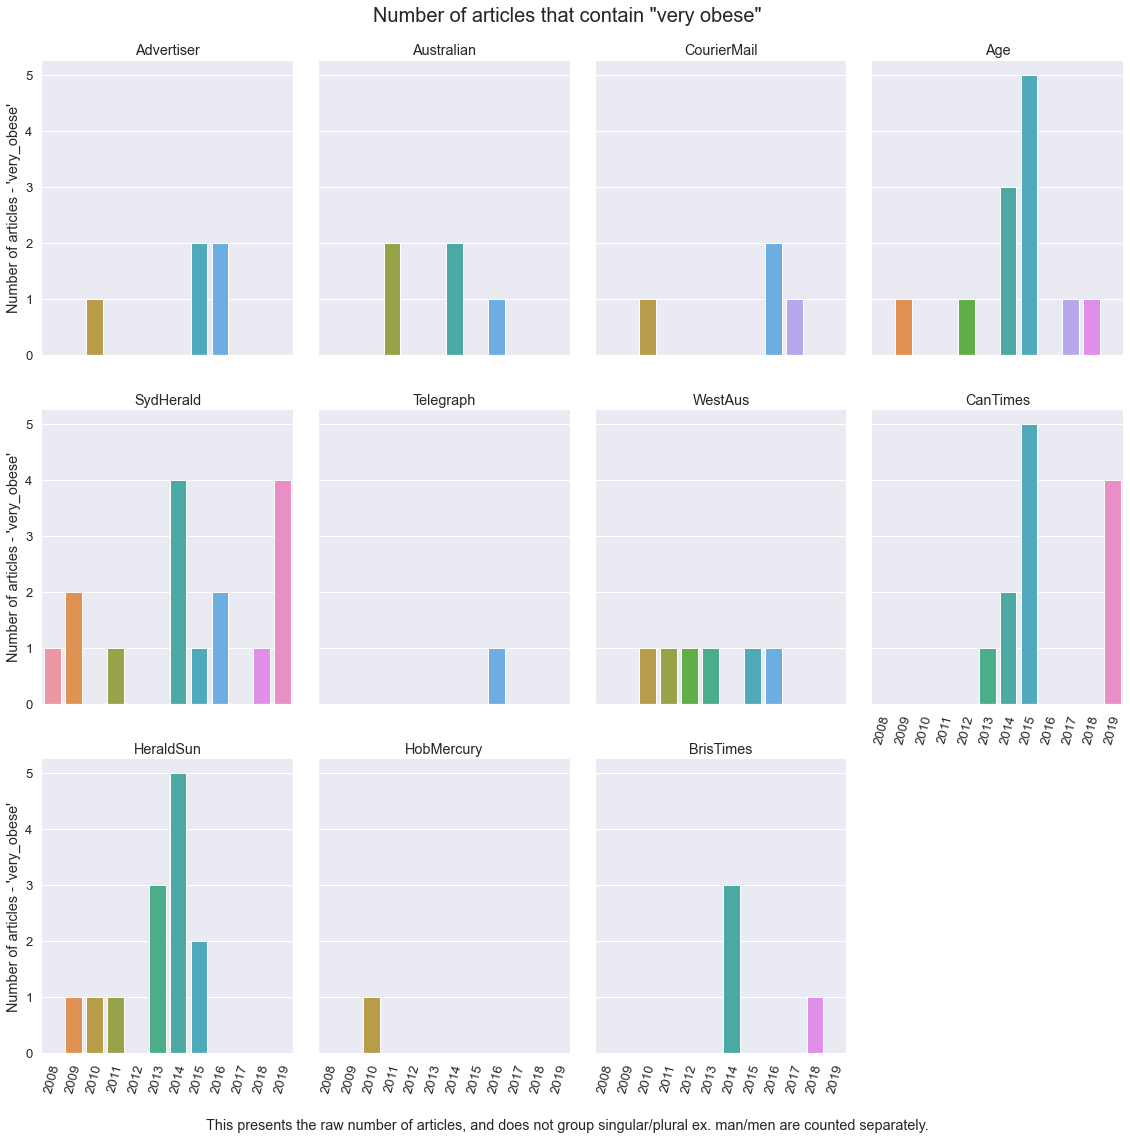

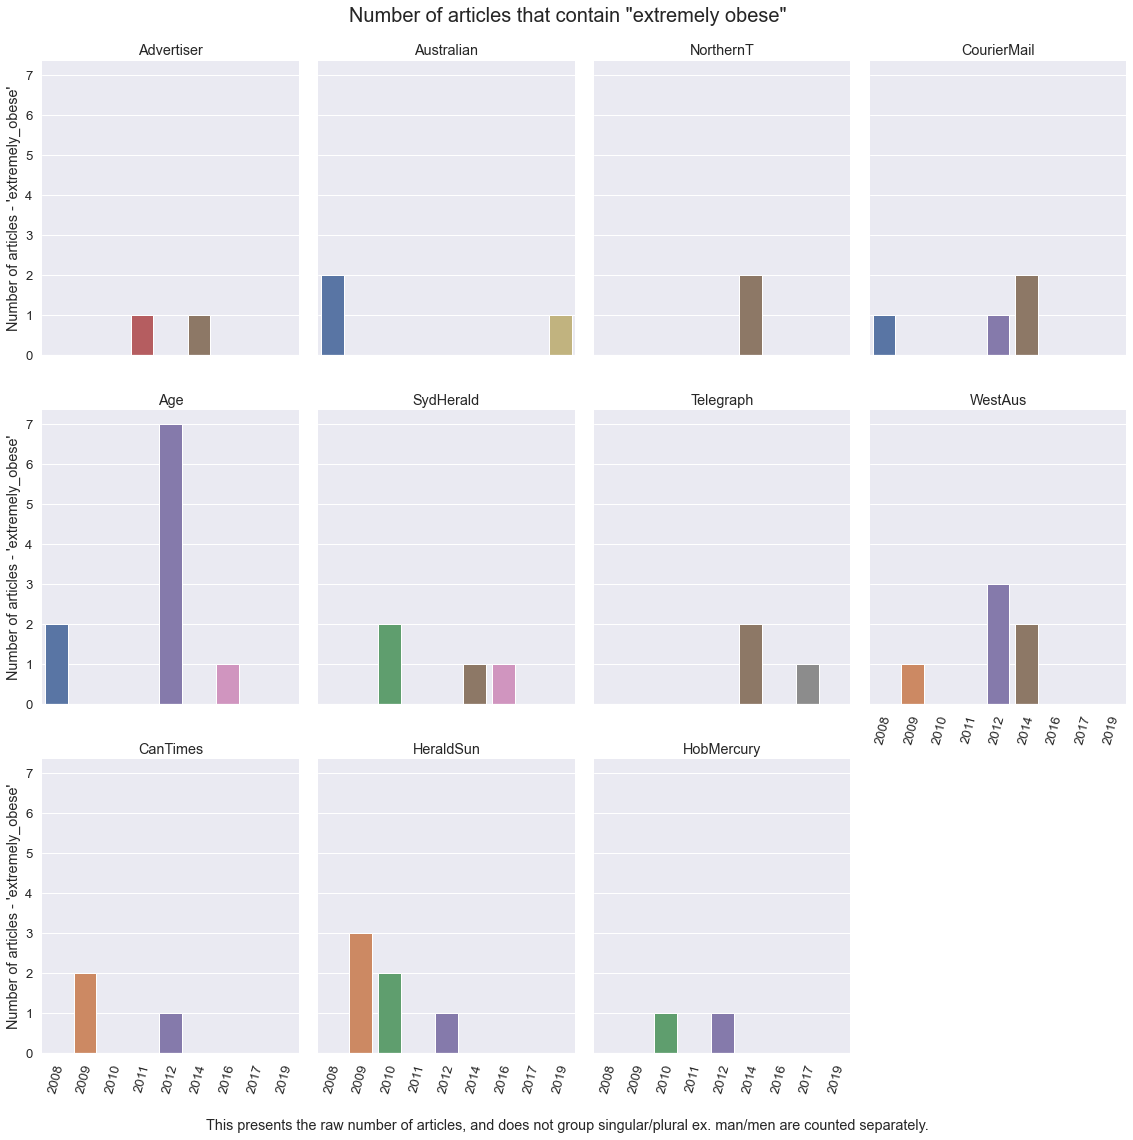

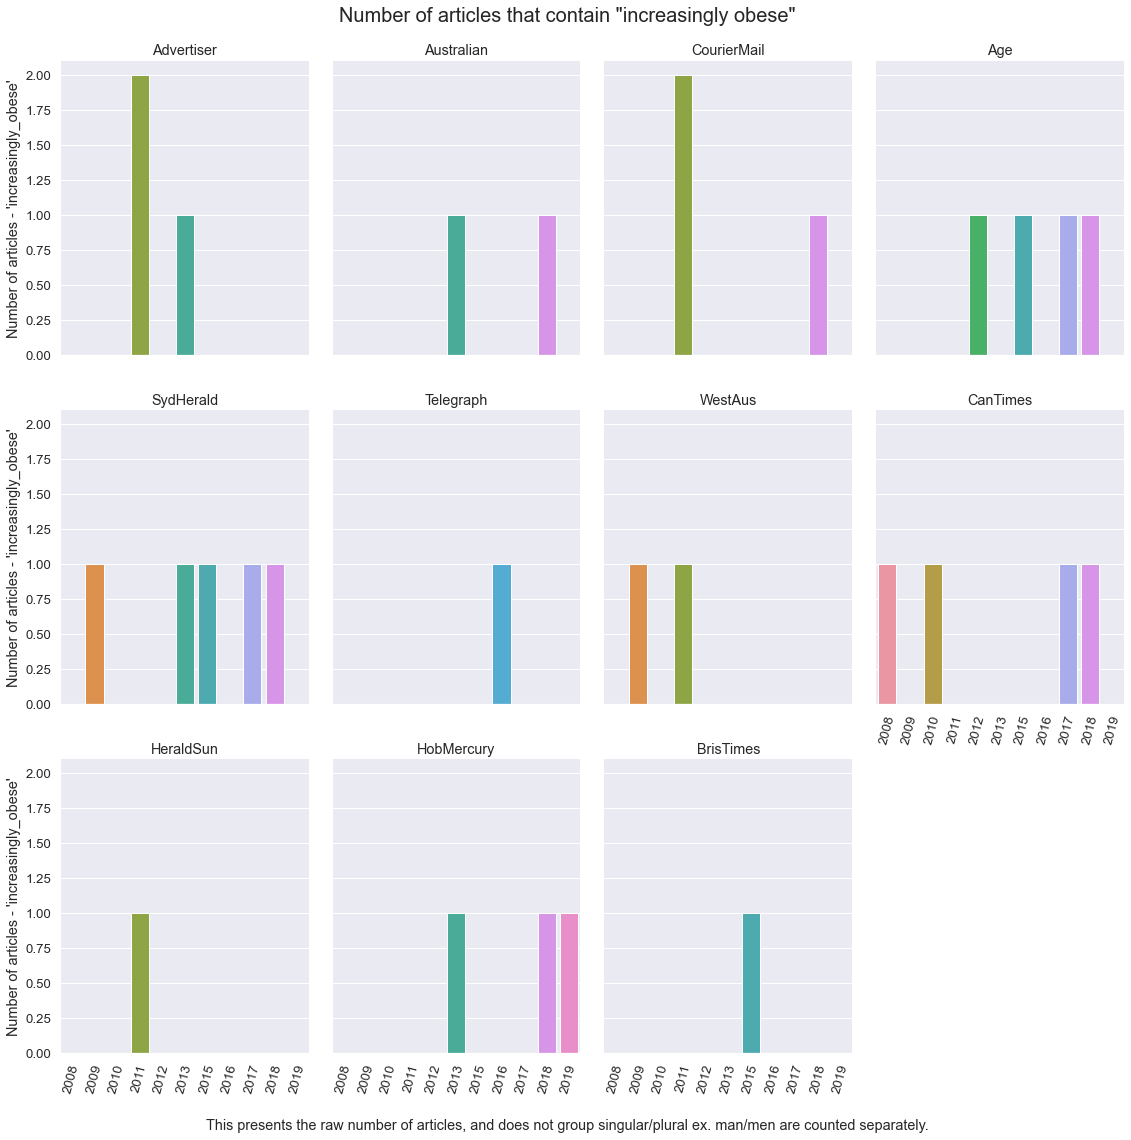

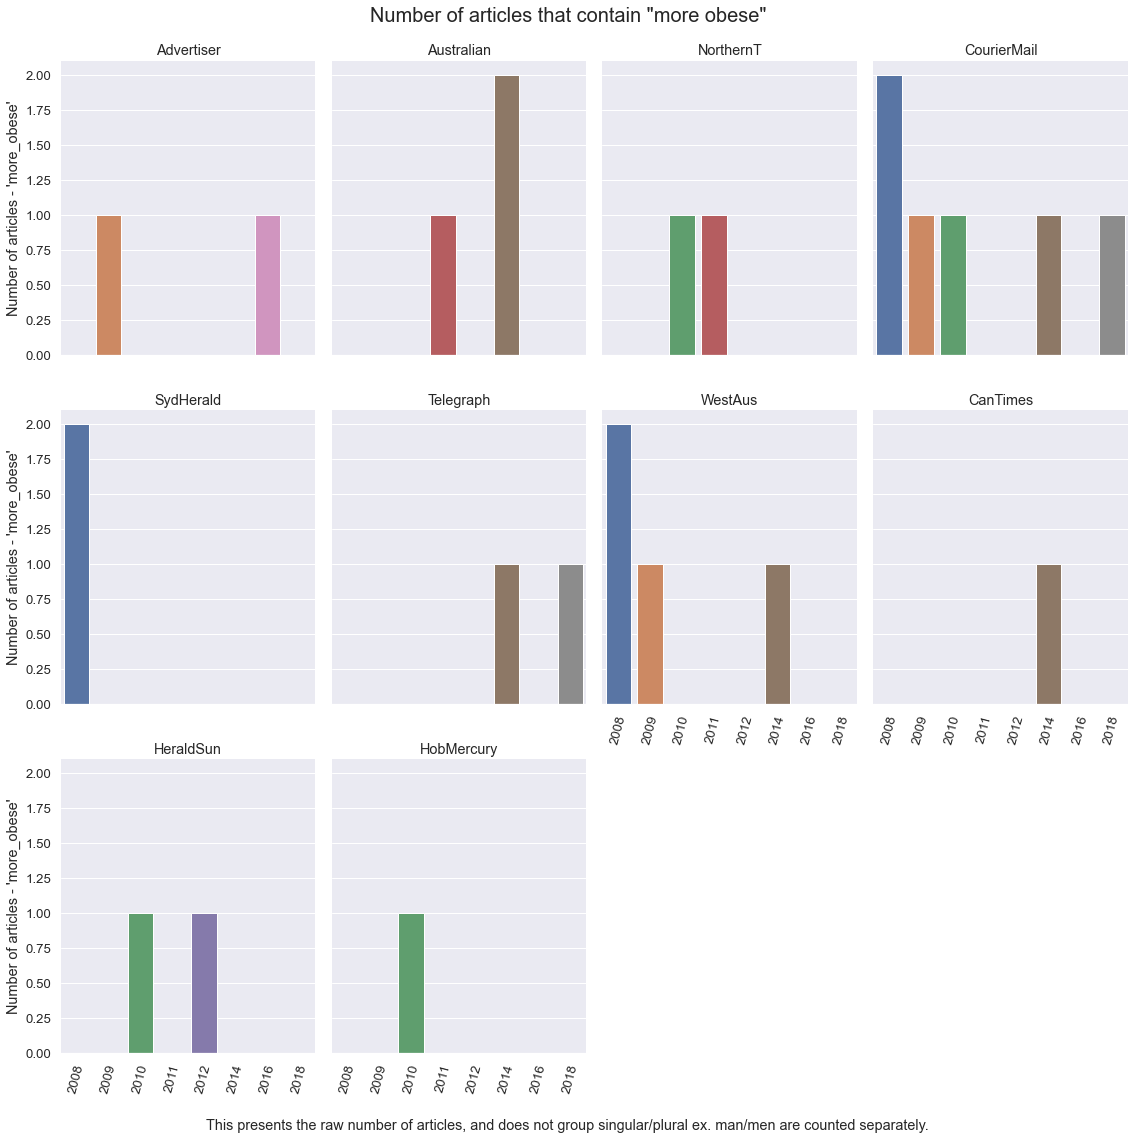

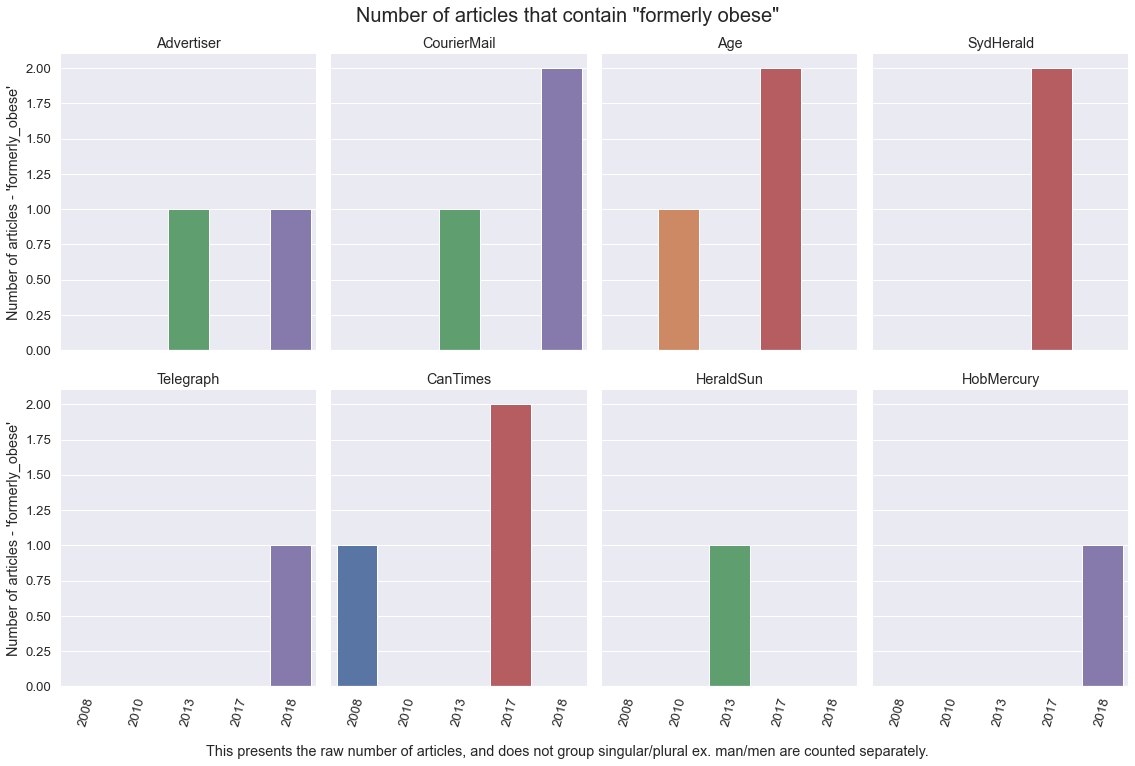

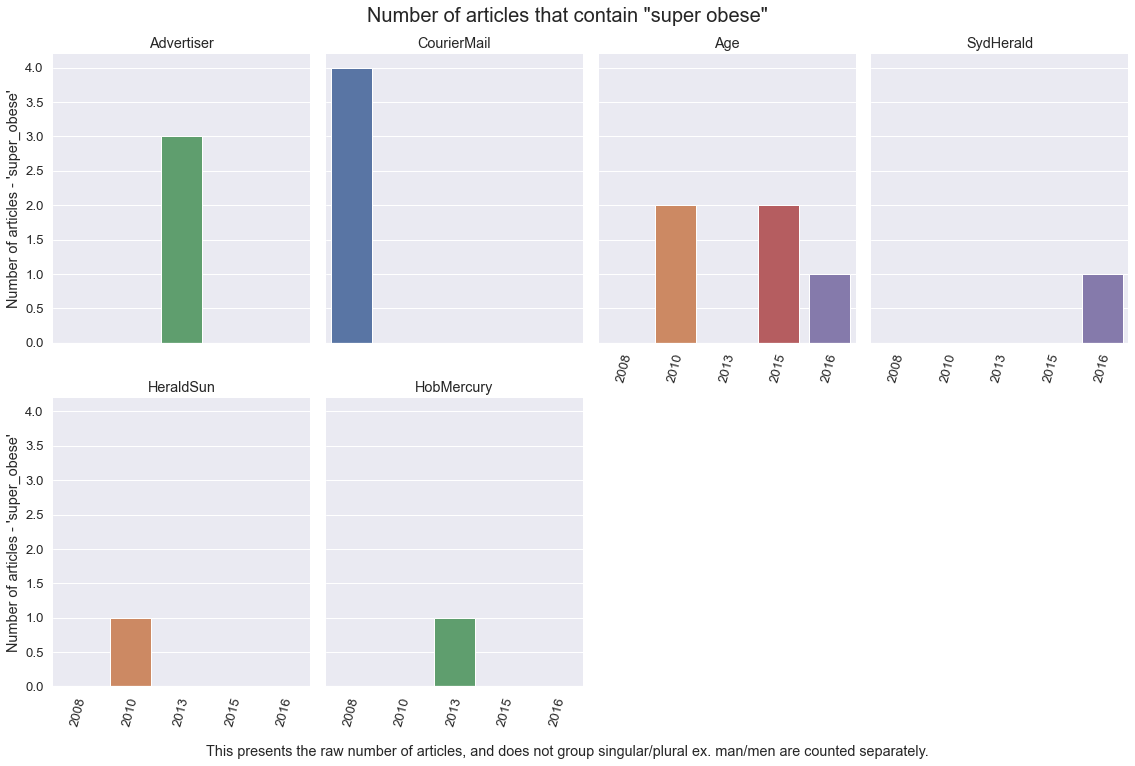

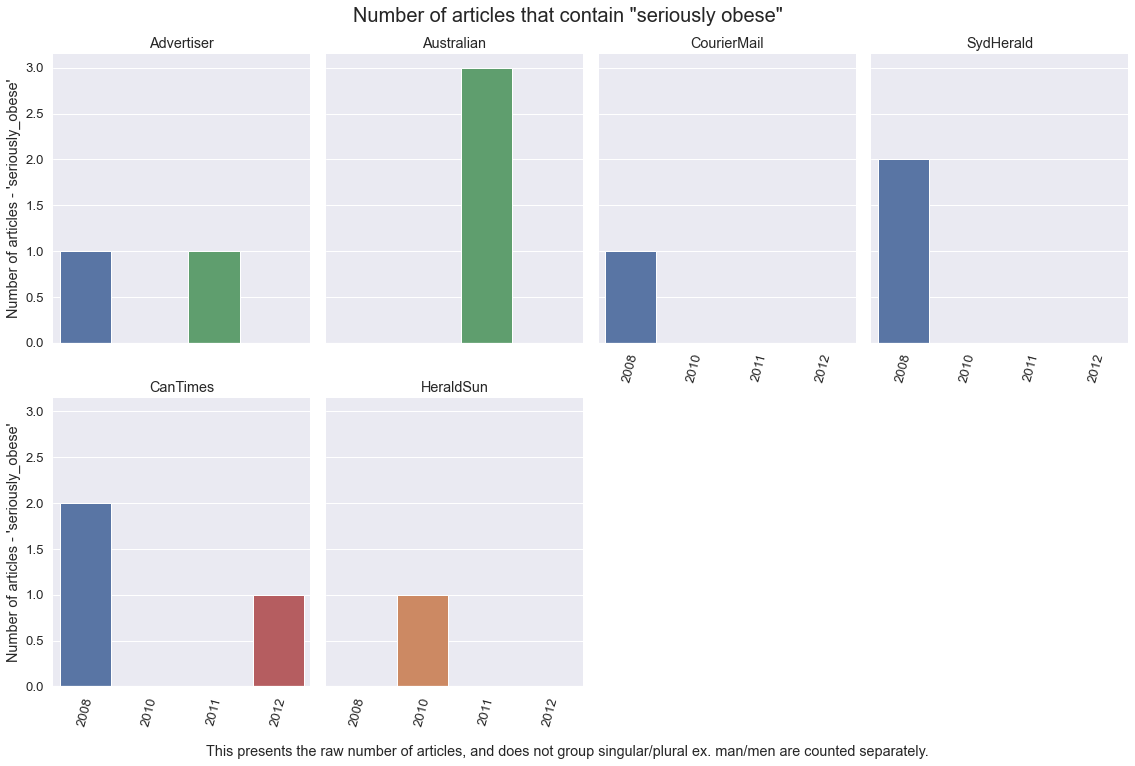

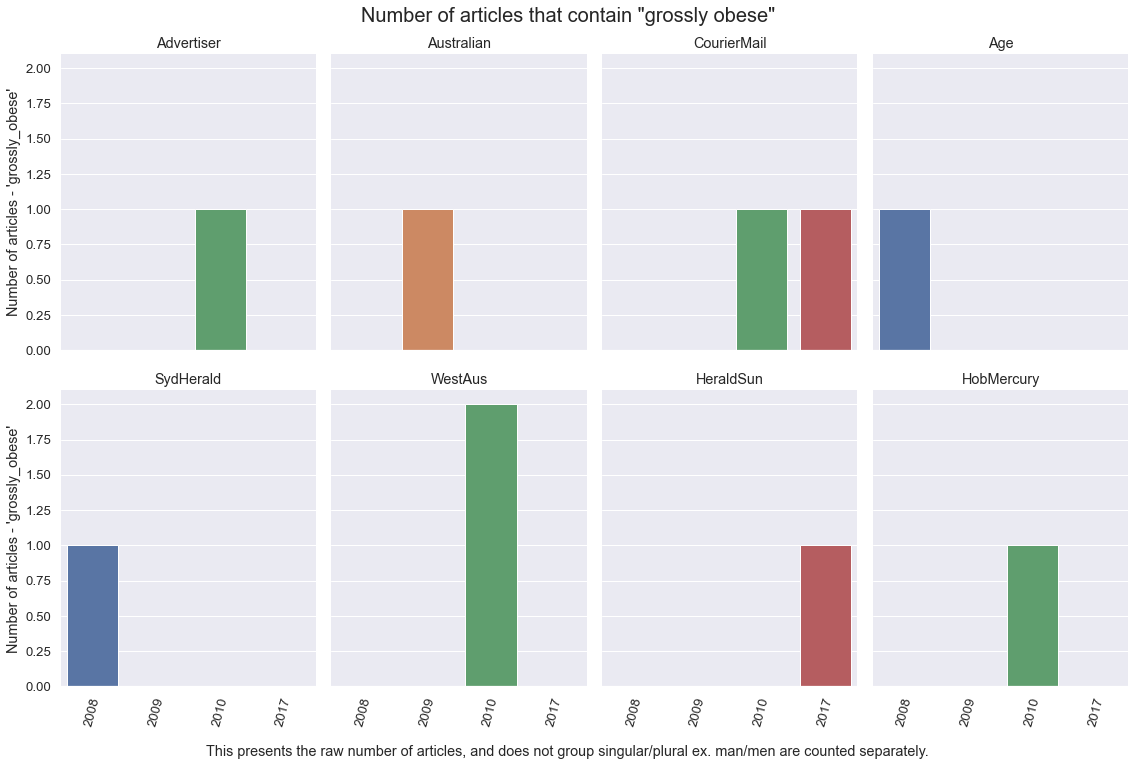

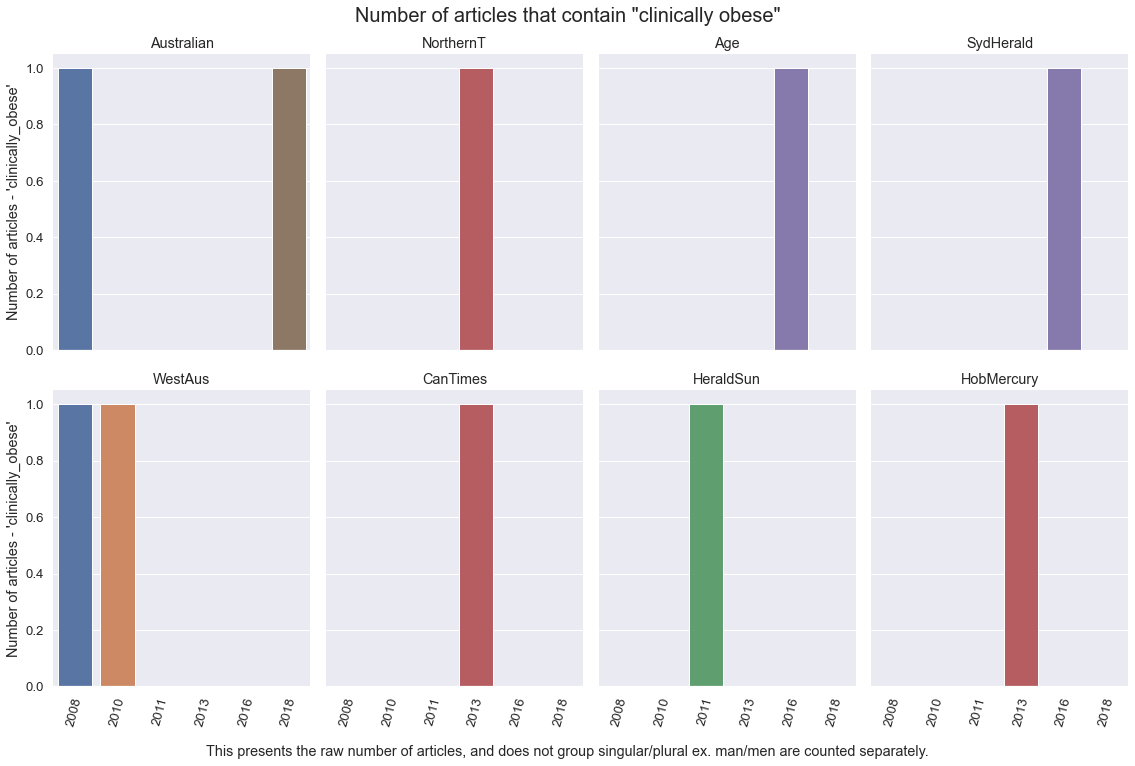

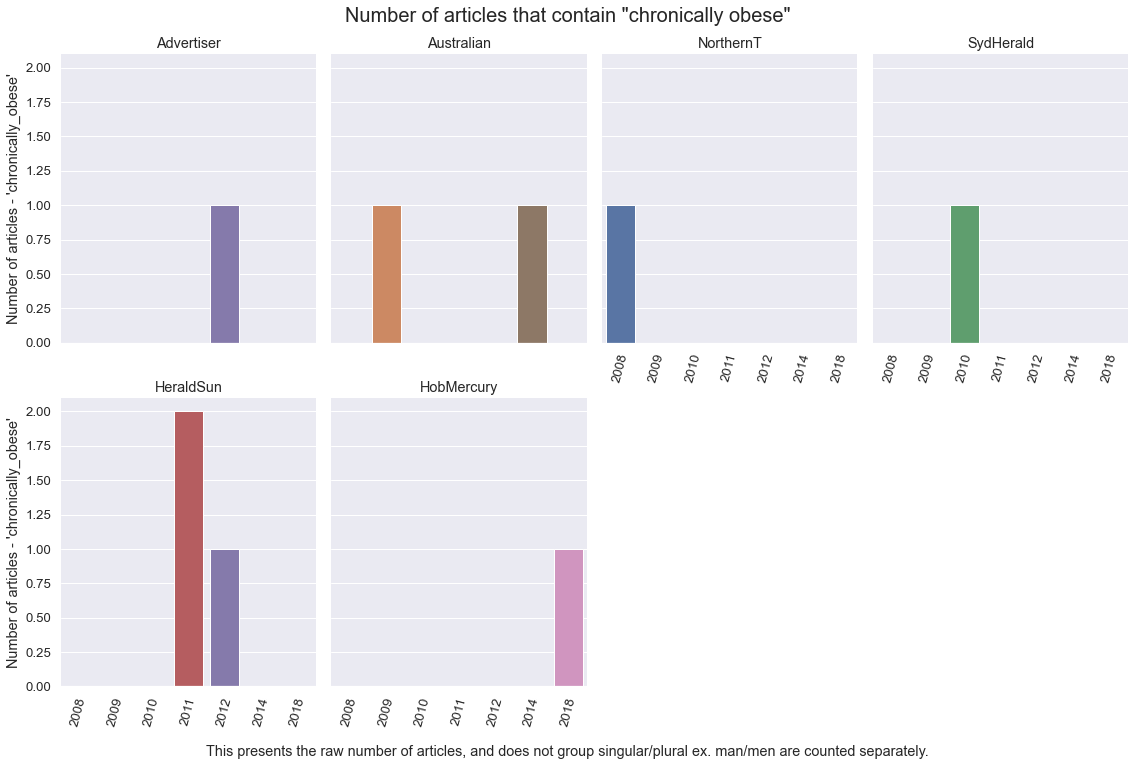

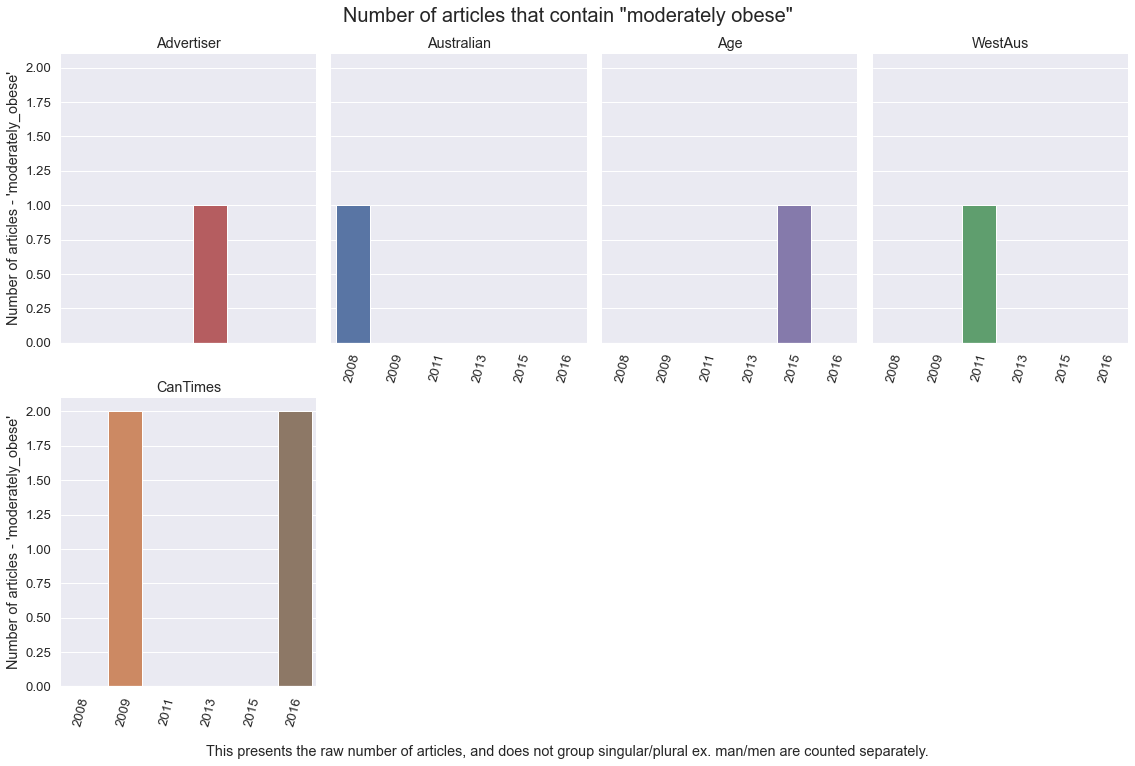

In [43]:
import matplotlib.pyplot as plt
from pathlib import Path
def wordplot(word, type, df, folder, filename, title, caption):
    '''
    Plots distribution of left word by source and year
    df needs to have left column
    '''
    mydf = df[df[type] == word]
    mydf['year'] = mydf['date'].dt.year
    plt.style.use('fast')
    sns.set_style("whitegrid")
    sns.set_theme(font_scale=1.2)


    g = sns.catplot(x="year", col="source", col_wrap=4,
                    data=mydf,kind="count",
                    aspect=.8)
    g.set_xticklabels(rotation=75)
    (g.set_axis_labels("", f"Number of articles - '{filename}'")
     .set_titles("{col_name}")
     .despine(left=True))
    g.fig.suptitle(title, fontsize =20, y=1.02)
    g.fig.text(0.5, -.02, caption, ha='center')
    Path(f"../docs/{folder}").mkdir(parents=True, exist_ok=True)
    g.figure.savefig(f"../docs/{folder}/{filename}.png", bbox_inches="tight")


# generate this plot for the 15 most frequent pairings
for x in obese_amod.left.value_counts().head(15).index.values.tolist():
    wordplot(x, df = obese_amod, type = 'left', folder="obese_amod_left",
             filename = f"{x}_obese",
             title=f'Number of articles that contain "{x} obese"',
             caption="This presents the raw number of articles, and does not group singular/plural ex. man/men are counted separately.")

In [47]:
obese_amod

,Unnamed: 0,metadata,body,title,source,fourdigitcode,byline,date,sentencenlp,sentence,text,tag,dep,left,right,headword
1,0,Strict diet for tubby arm of the law\nThe Adve...,\n\nAUTHORITIES in Mexico City are putting pol...,Strict Diet For Tubby Arm Of The Law,Advertiser,0018,"Agencies, Mexico City",2009-10-17,"[(Seven, out, of, 10, officers, are, obese, in...",Mexico is the second-most obese country in the...,obese,JJ,amod,second,obese,country
12,5,SA ambos carry 347kg patient\nThe Advertiser (...,\n\nAMBULANCE officers are carrying morbidly o...,Sa Ambos Carry 347Kg Patient,Advertiser,0009,None,2009-10-07,"[(AMBULANCE, officers, are, carrying, morbidly...",AMBULANCE officers are carrying morbidly obese...,obese,JJ,amod,morbidly,obese,patients
13,5,SA ambos carry 347kg patient\nThe Advertiser (...,\n\nAMBULANCE officers are carrying morbidly o...,Sa Ambos Carry 347Kg Patient,Advertiser,0009,None,2009-10-07,"[(AMBULANCE, officers, are, carrying, morbidly...",Manager of the bariatric ambulance team Dean C...,obese,JJ,amod,obese,obese,patients
32,21,READERS SUNDAY ROAST' We're dying to be comfor...,\n\nIN this day and age lifestyles have become...,Readers Sunday Roast' We'Re Dying To Be Comfor...,Advertiser,0020,Dave Bishop,2009-10-18,"[(Many, experts, are, telling, us, that, the, ...",Many experts are telling us that the next grou...,obese,JJ,amod,somewhat,obese,children
37,25,Get a move on to fight both bulge and blues\nT...,"\n\nOBESITY and depression are closely linked,...",Get A Move On To Fight Both Bulge And Blues,Advertiser,0010,"Tory Shepherd, Health Reporter",2009-10-09,"[(In, an, editorial, published, in, yesterday,...",In an editorial published in yesterday's Briti...,obese,JJ,amod,obese,obese,people
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52517,26275,Warning to lift Olympic sports funding or expe...,\n\nAustralia needs to pump an extra $60 milli...,Warning To Lift Olympic Sports Funding Or Expe...,BrisTimes,0003,Michael Gleeson,2018-10-24,"[(He, said, improved, funding, was, crucial, t...","""The only gold medal will be the race to be th...",obese,JJ,amod,most,obese,nation
52544,26282,The disease that changed history: How a Queens...,\n\nAustralia's obesity epidemic has created a...,The Disease That Changed History: How A Queens...,BrisTimes,0001,Lucy Stone,2018-11-05,"[(Australia, 's, obesity, epidemic, has, creat...",Her research will also investigate the long-la...,obese,JJ,amod,obese,obese,person
52546,26282,The disease that changed history: How a Queens...,\n\nAustralia's obesity epidemic has created a...,The Disease That Changed History: How A Queens...,BrisTimes,0001,Lucy Stone,2018-11-05,"[(Australia, 's, obesity, epidemic, has, creat...",Her research will also investigate the long-la...,obese,JJ,amod,obese,obese,person
52552,26283,Here comes the sun: Defending our summer rays\...,\n\nWatching the cricket with Dad in the last ...,Here Comes The Sun: Defending Our Summer Rays,BrisTimes,0005,Mark Whittaker,2018-11-23,"[(At, the, same, time, ,, there, 's, a, lot, o...",She and other researchers at Perth's Telethon ...,obese,JJ,amod,obese,obese,mice


If we look at the right, the results are not as interesting.

In [8]:
obese_amod.right.value_counts().head(n=10)


obese          5881
overweight       50
and              10
,                 5
underweight       4
developing        4
healthy           3
low               3
diabetic          3
naked             3
Name: right, dtype: int64

We can also look at the head word that obese is modifying - who or what are obese?

In [9]:
obese_amod.headword.value_counts()

people       1196
children      506
women         451
patients      418
adults        265
             ... 
socialist       1
kiddies         1
shadow          1
omelet          1
monster         1
Name: headword, Length: 629, dtype: int64

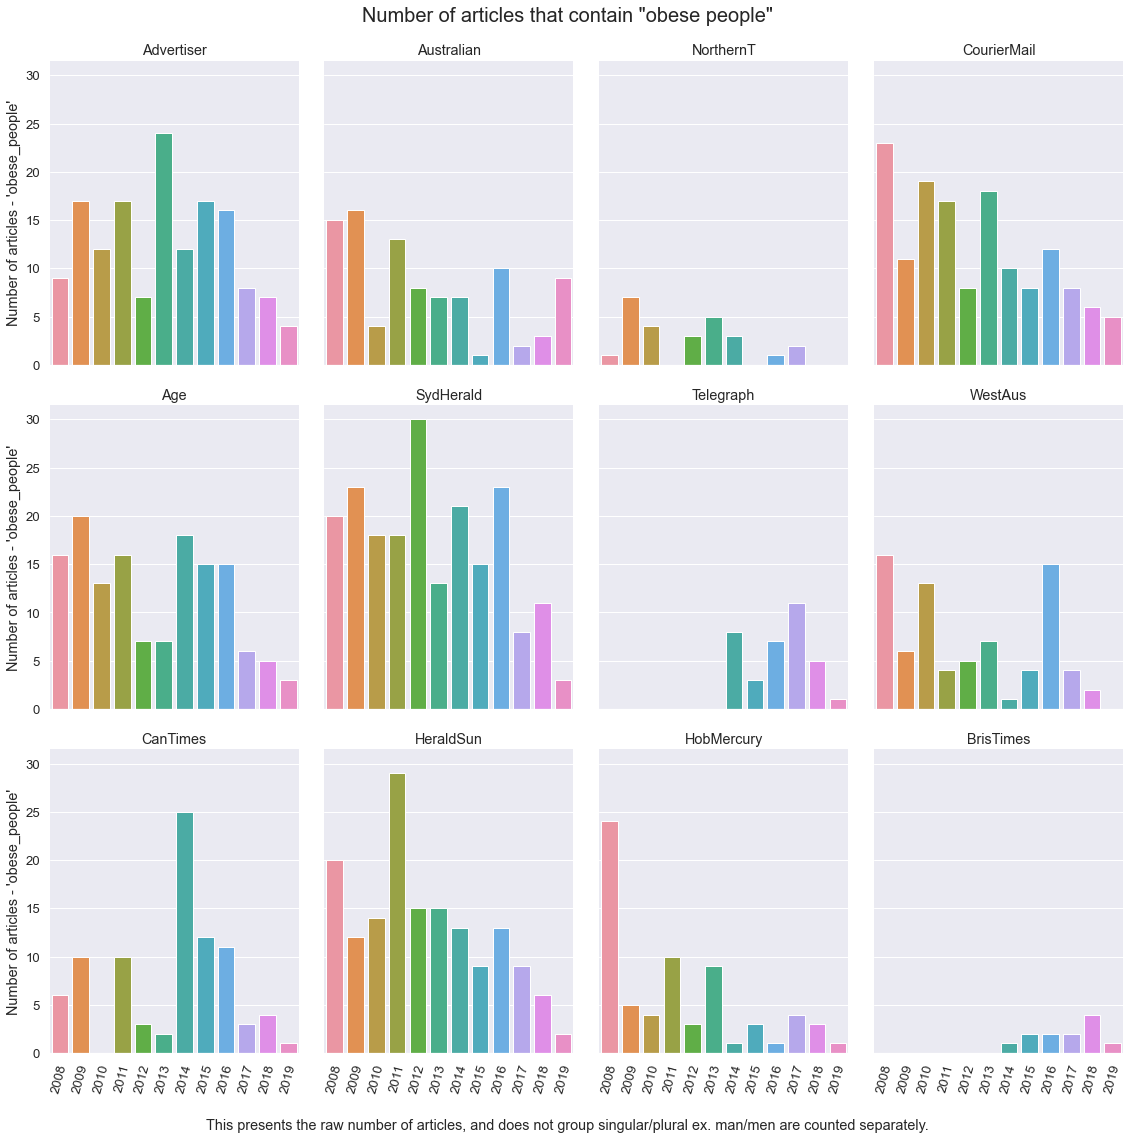

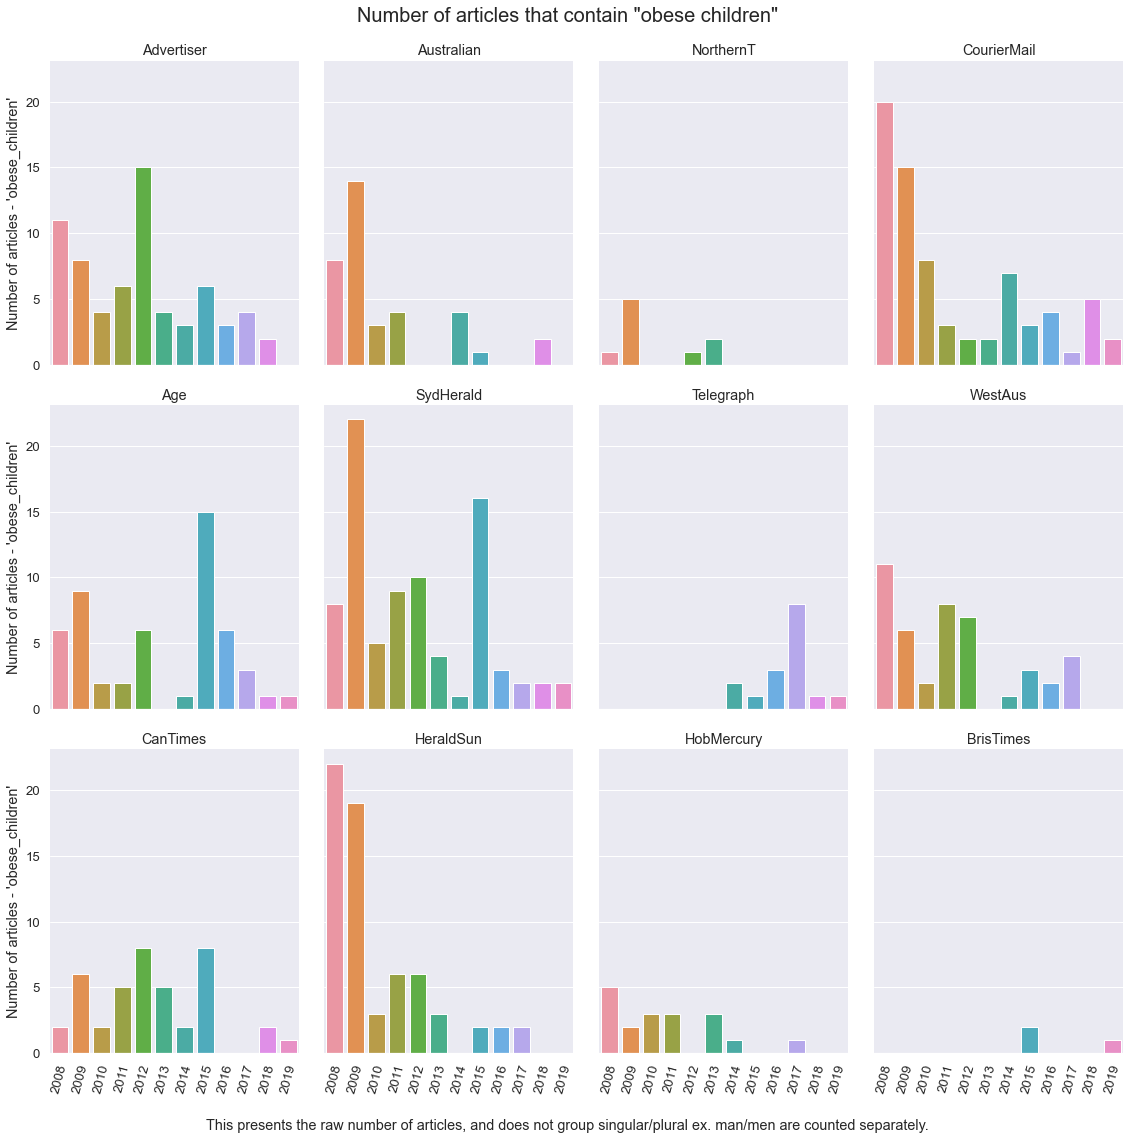

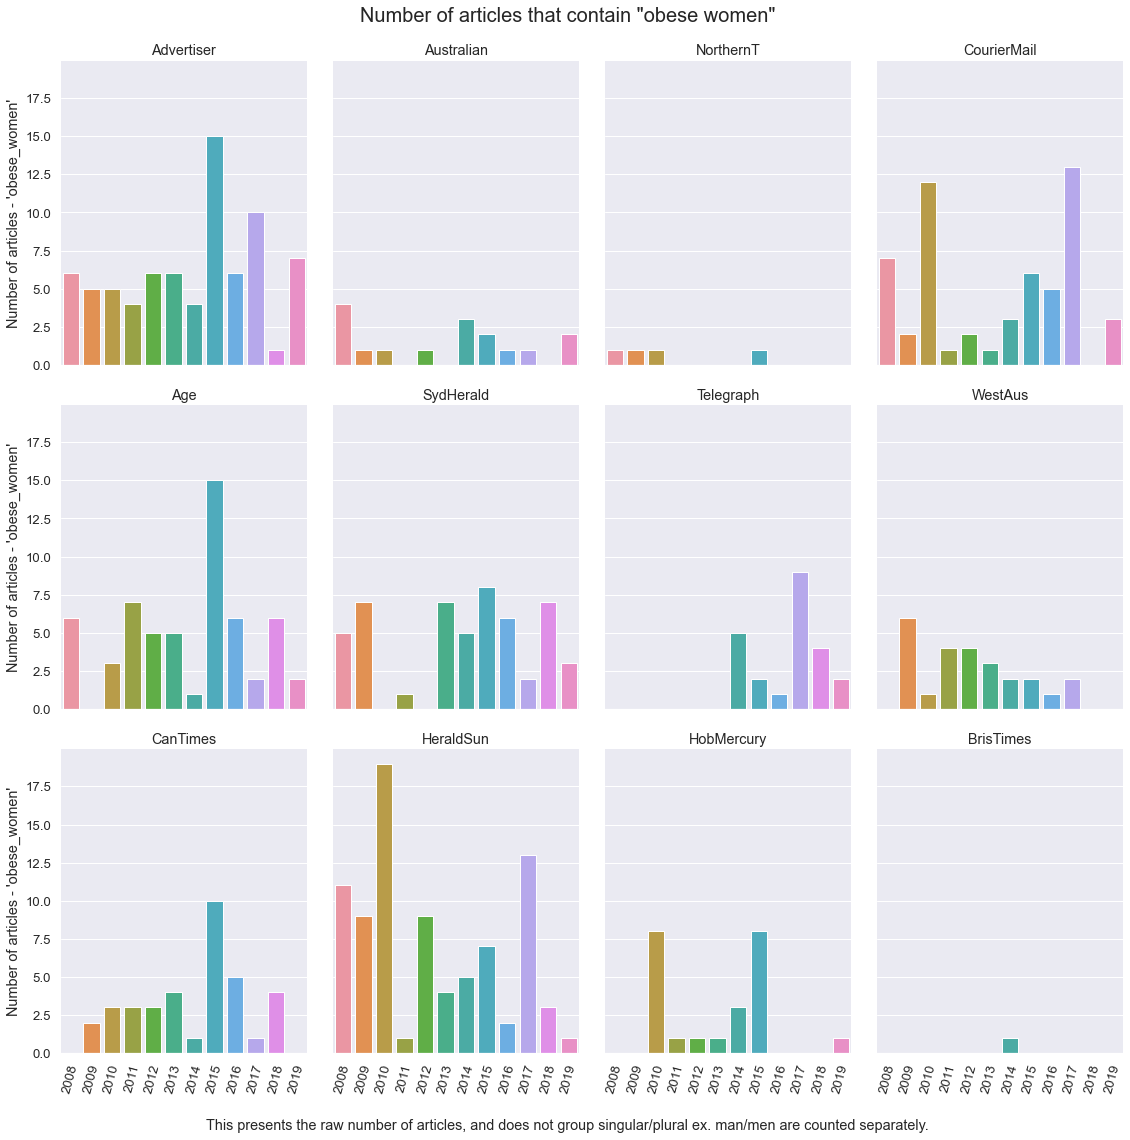

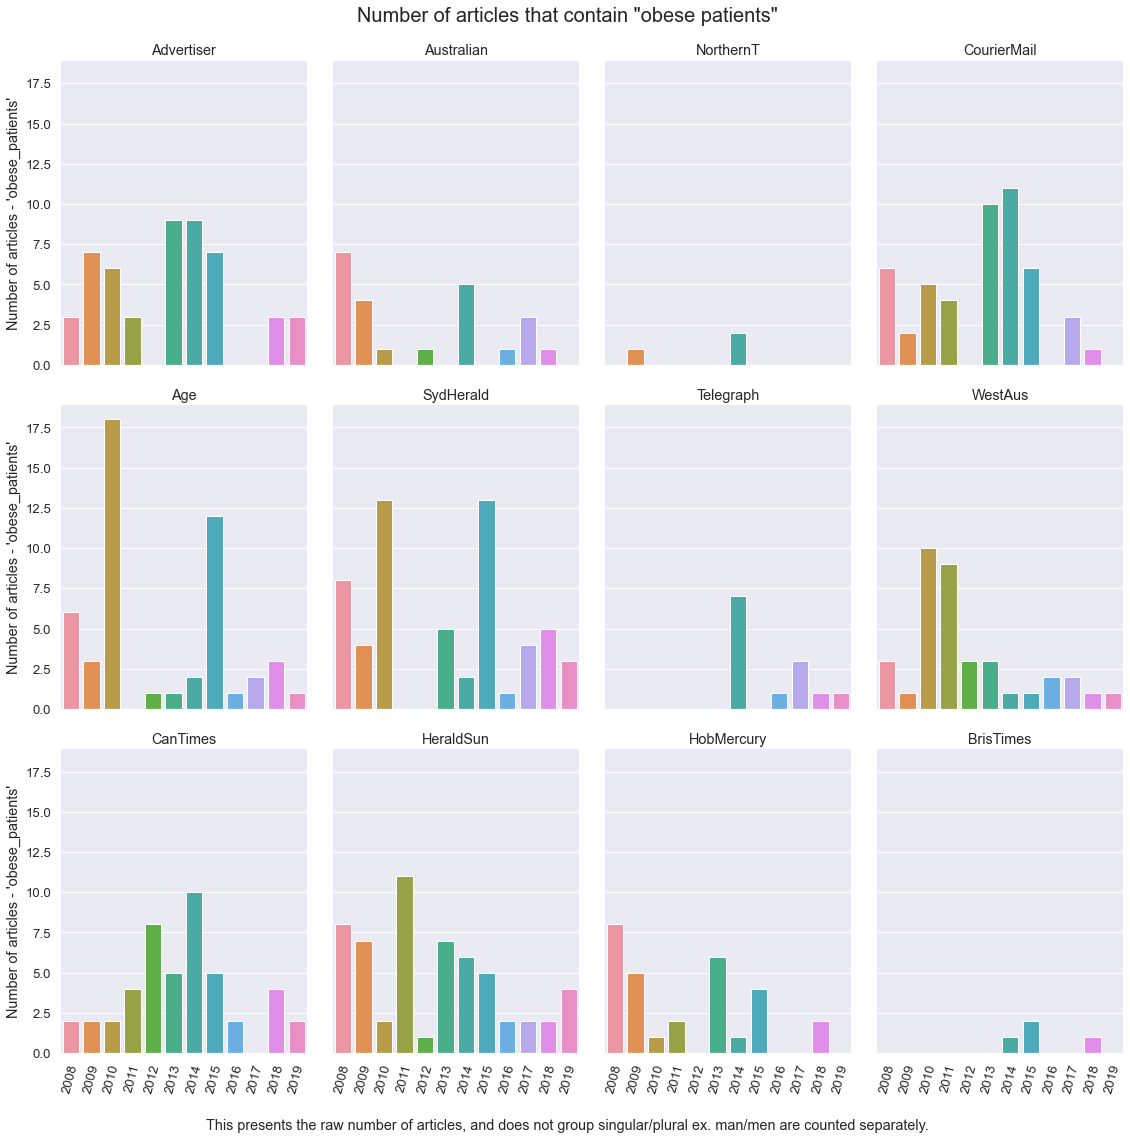

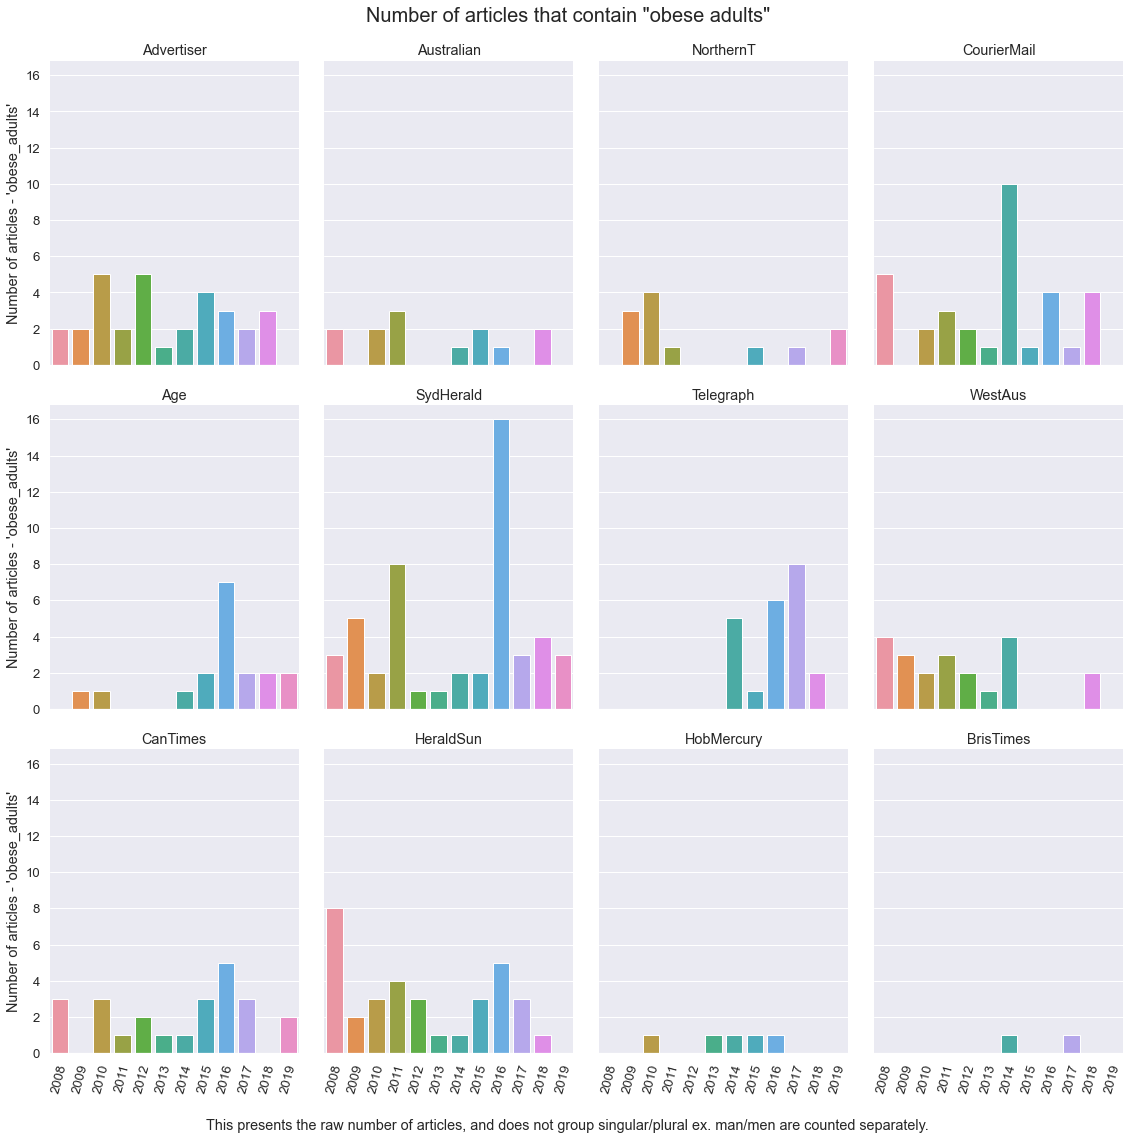

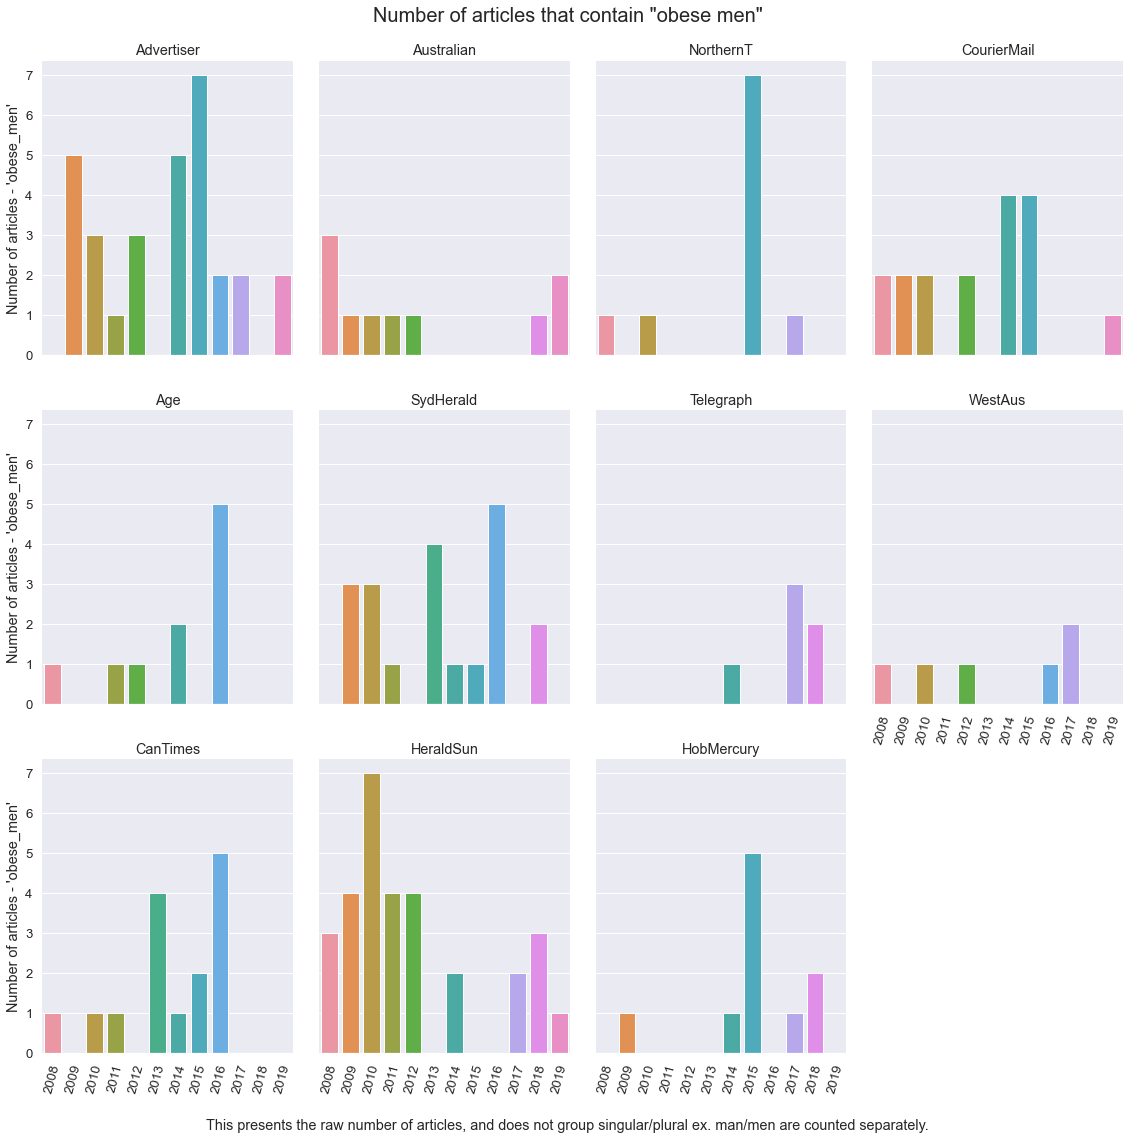

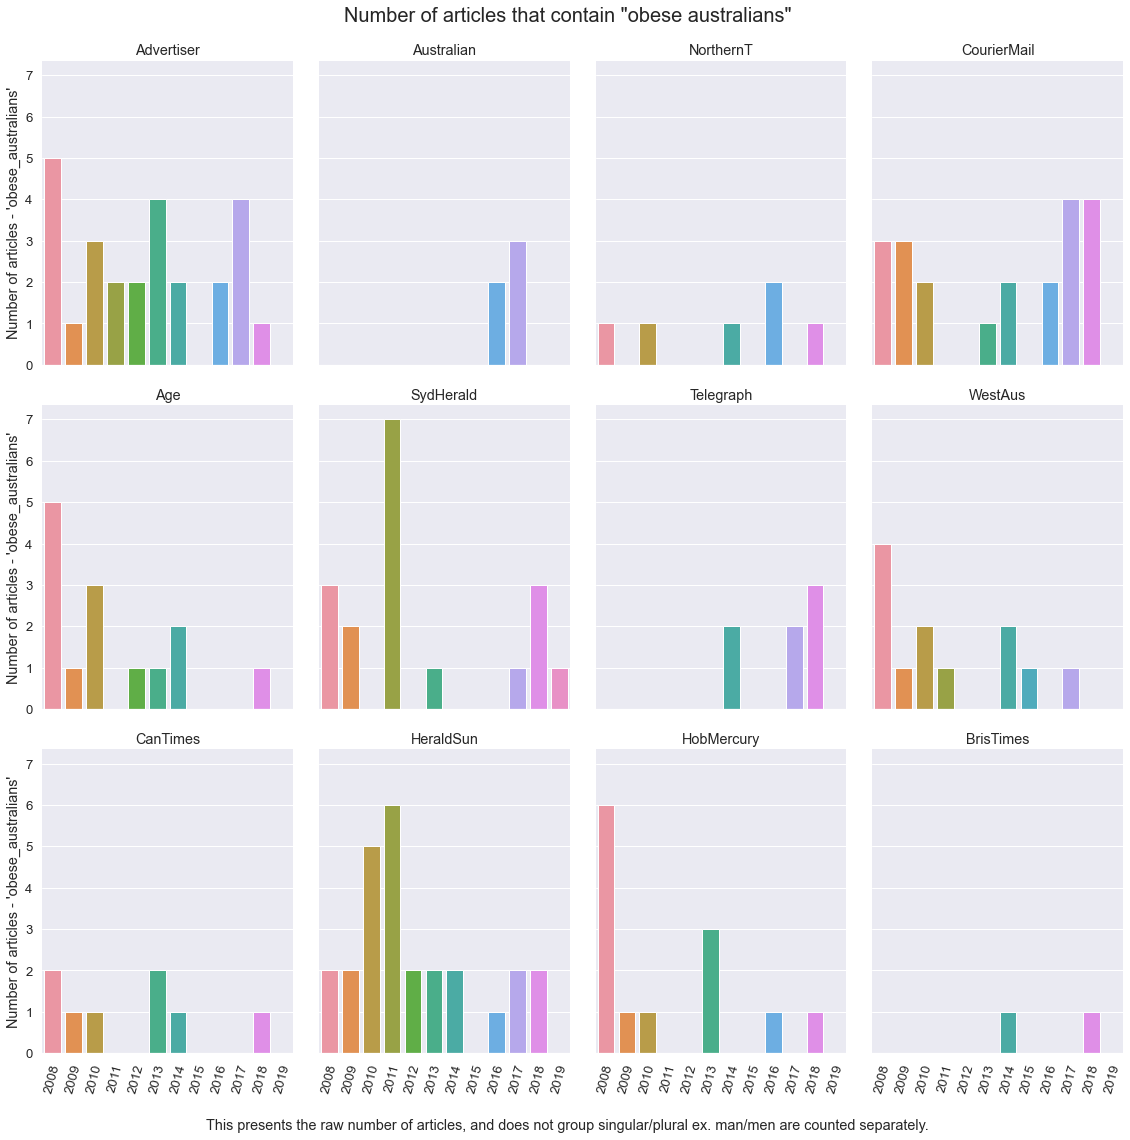

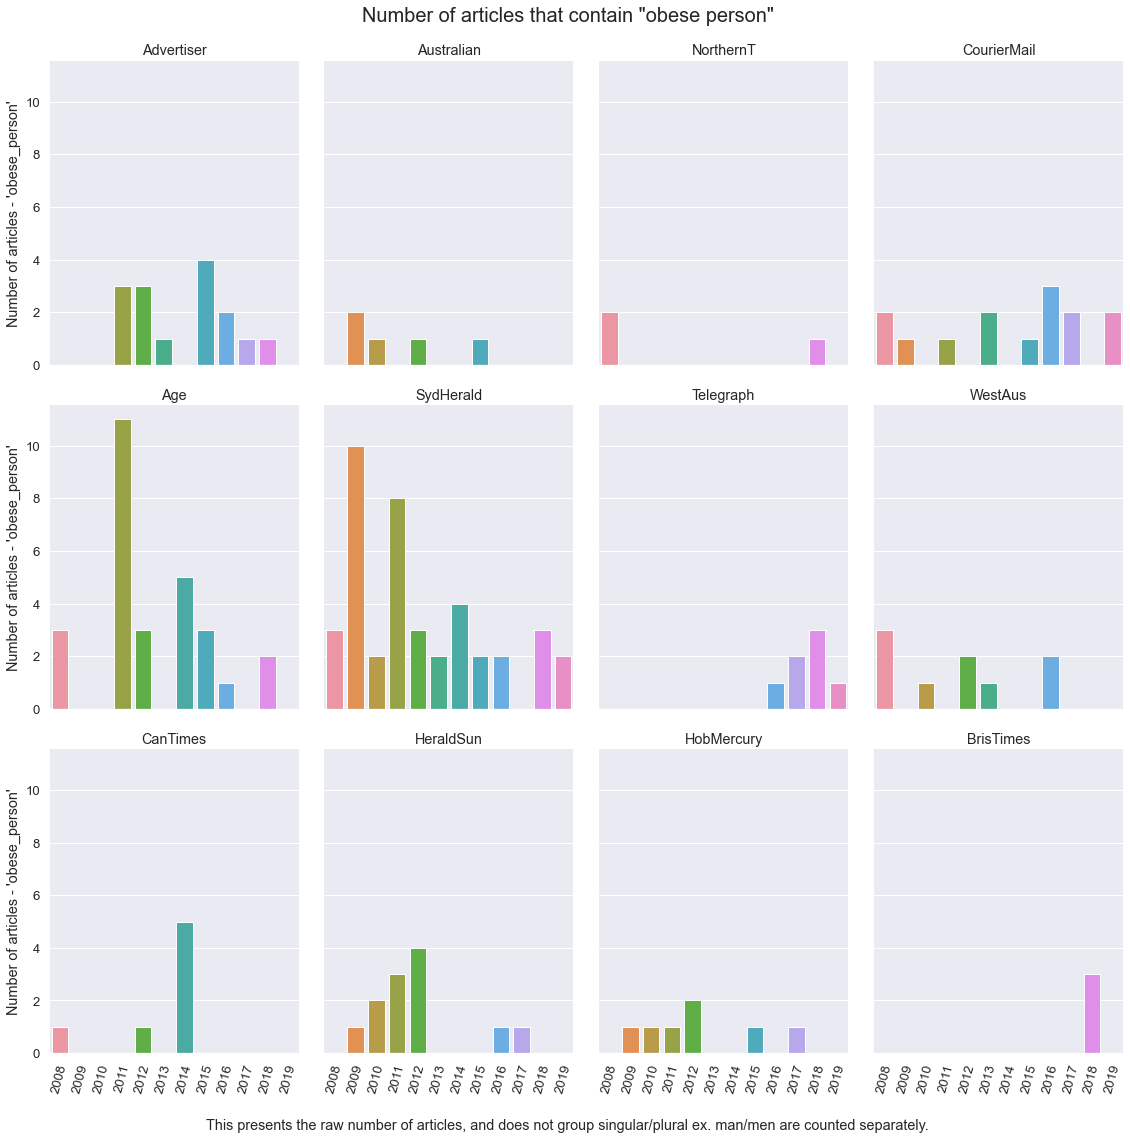

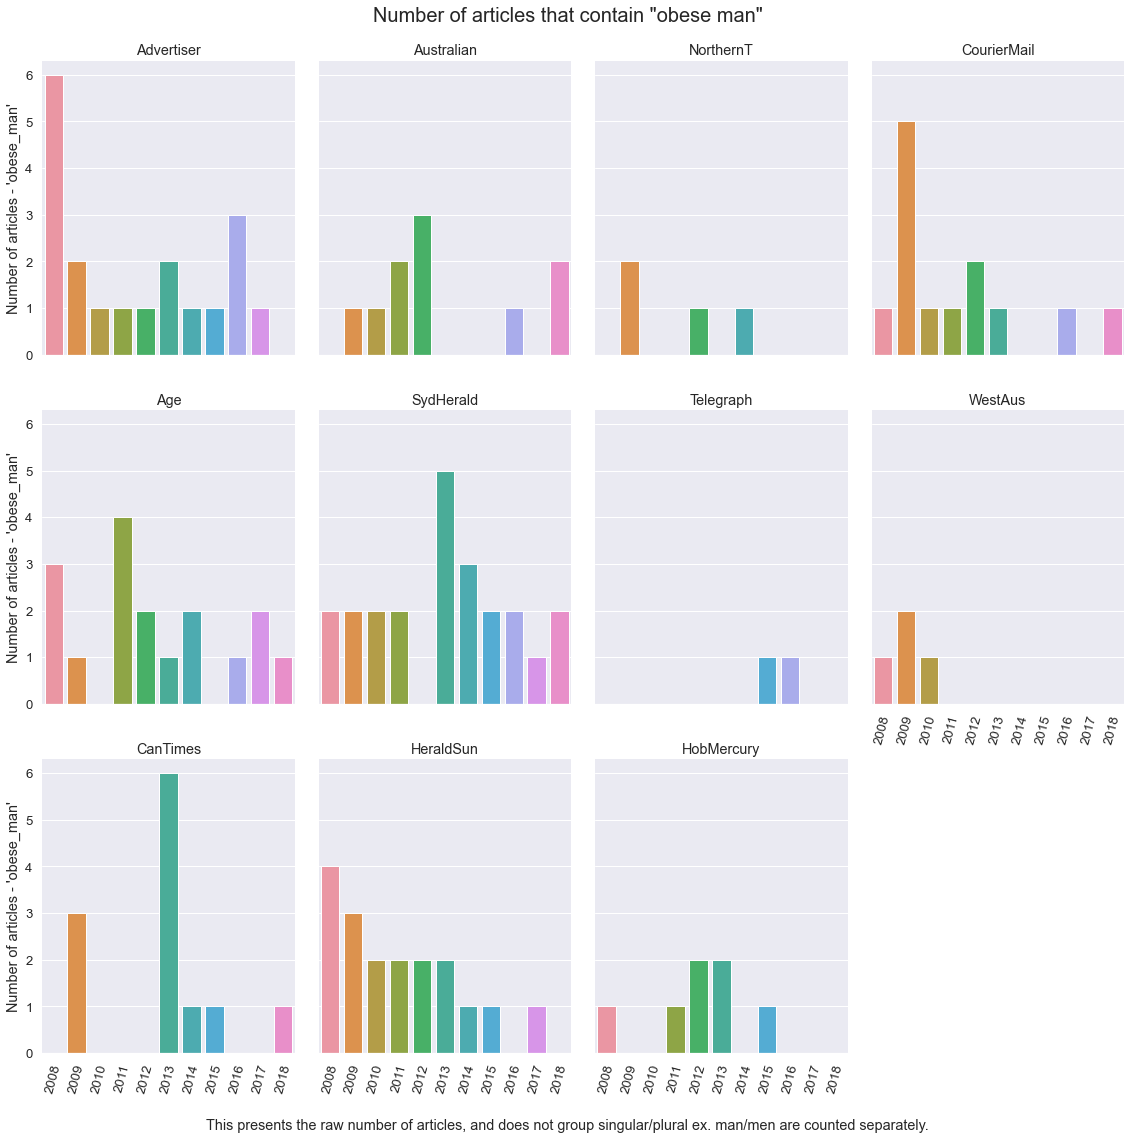

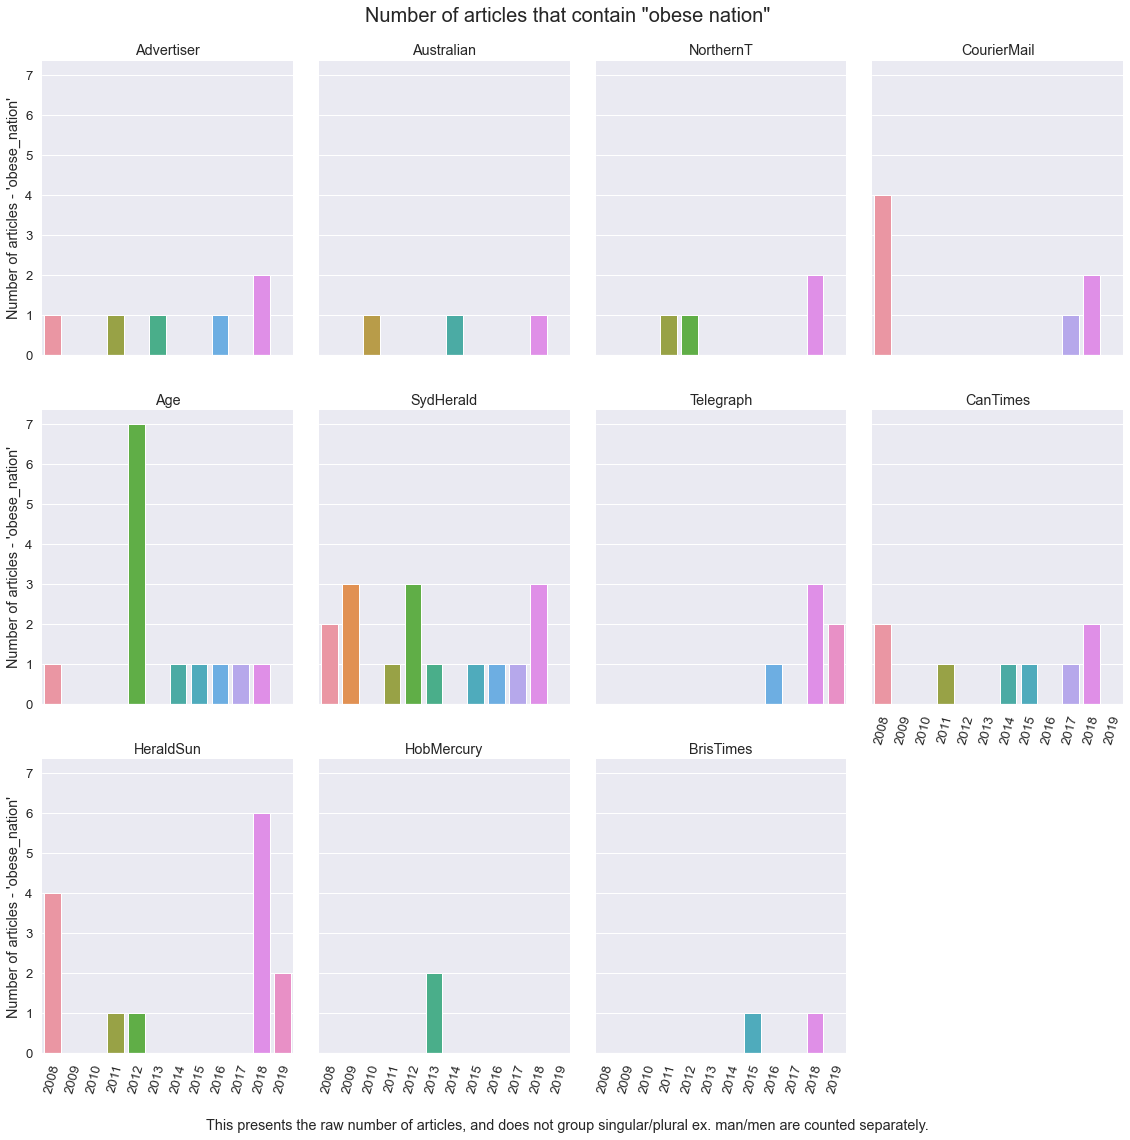

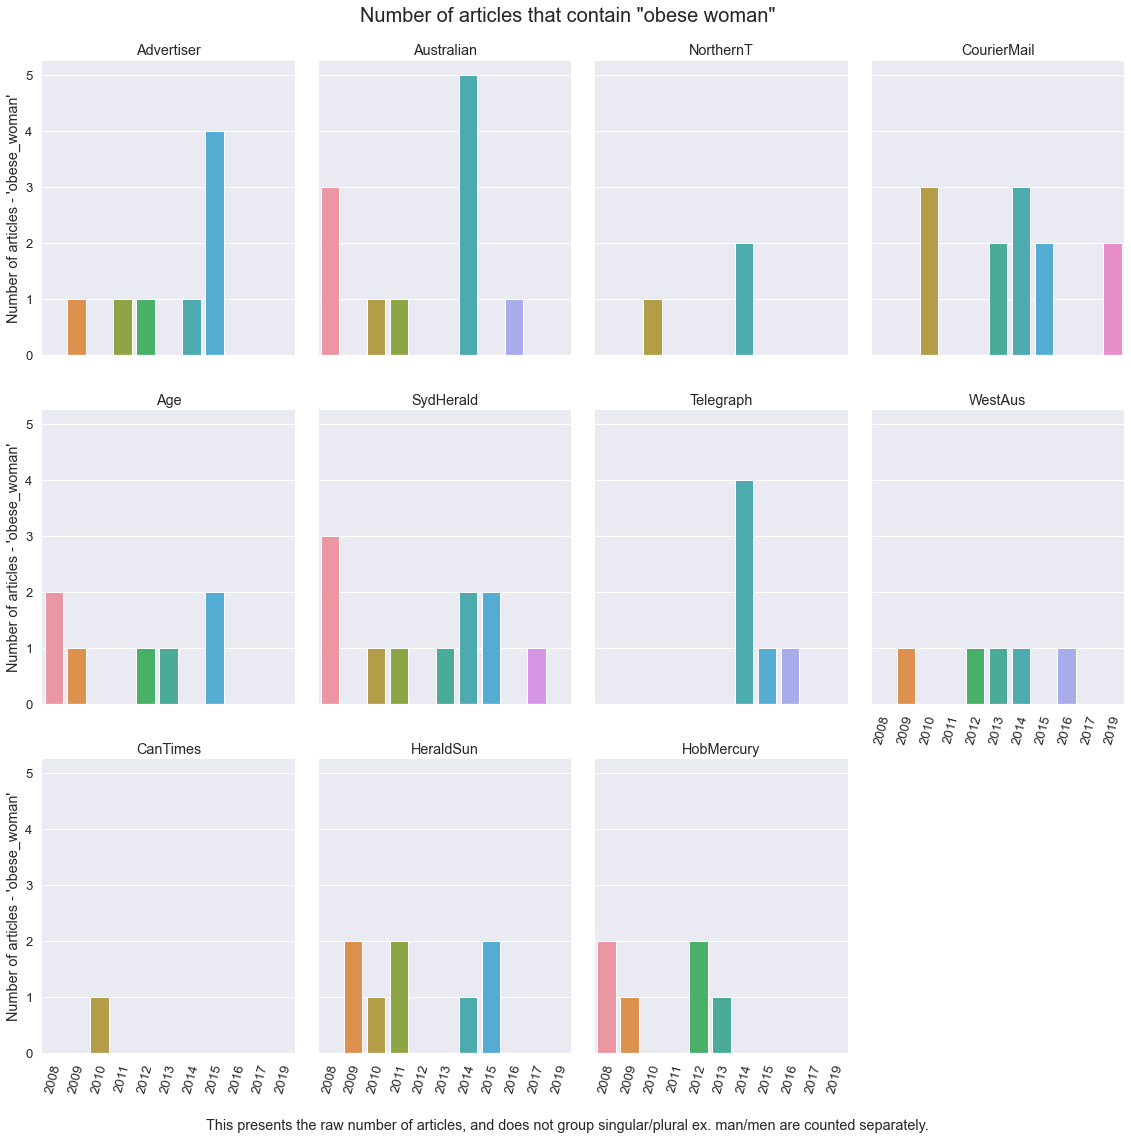

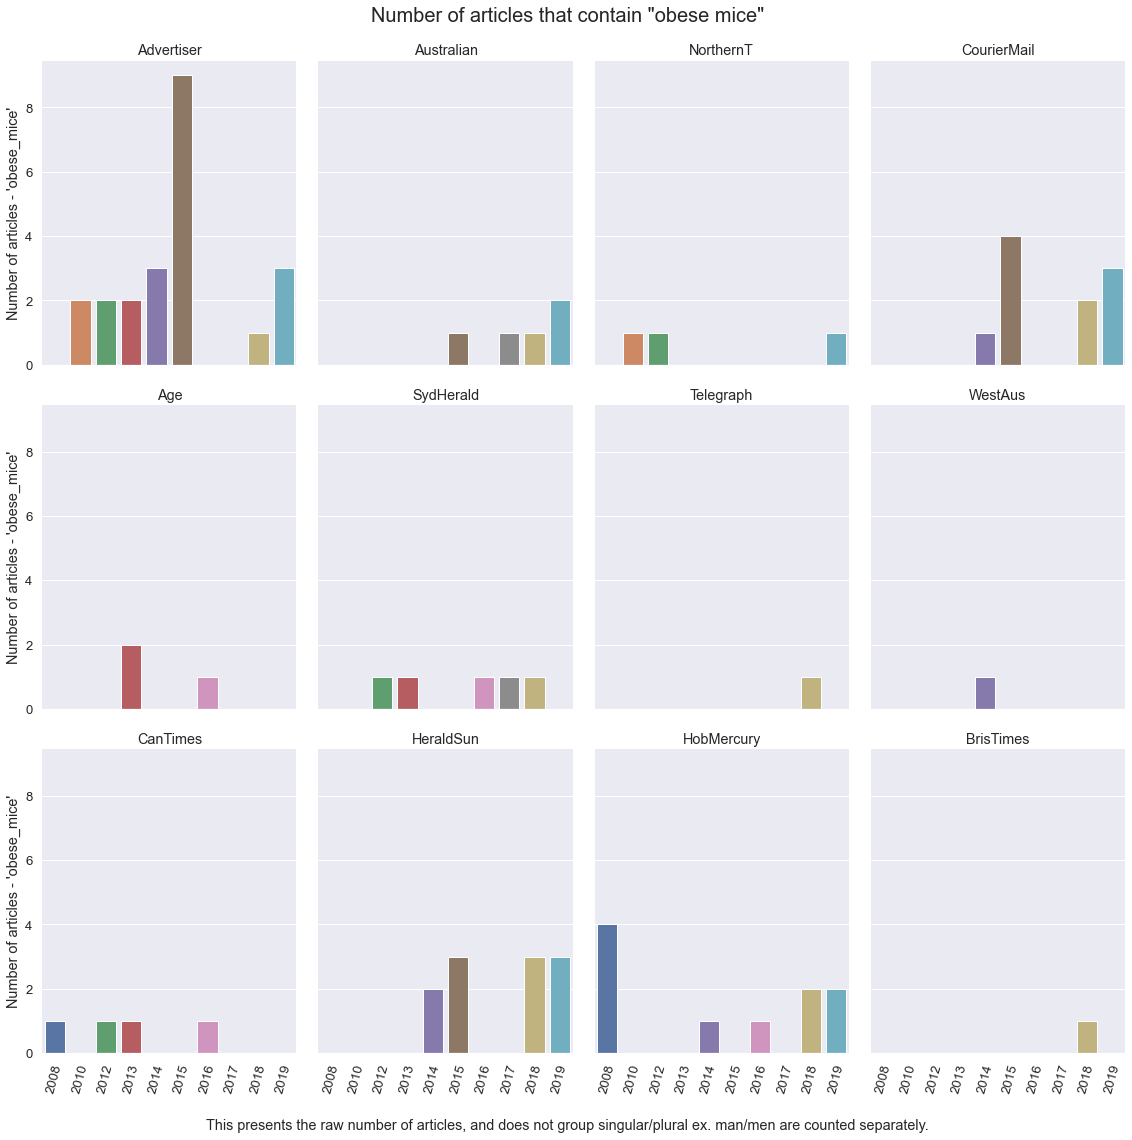

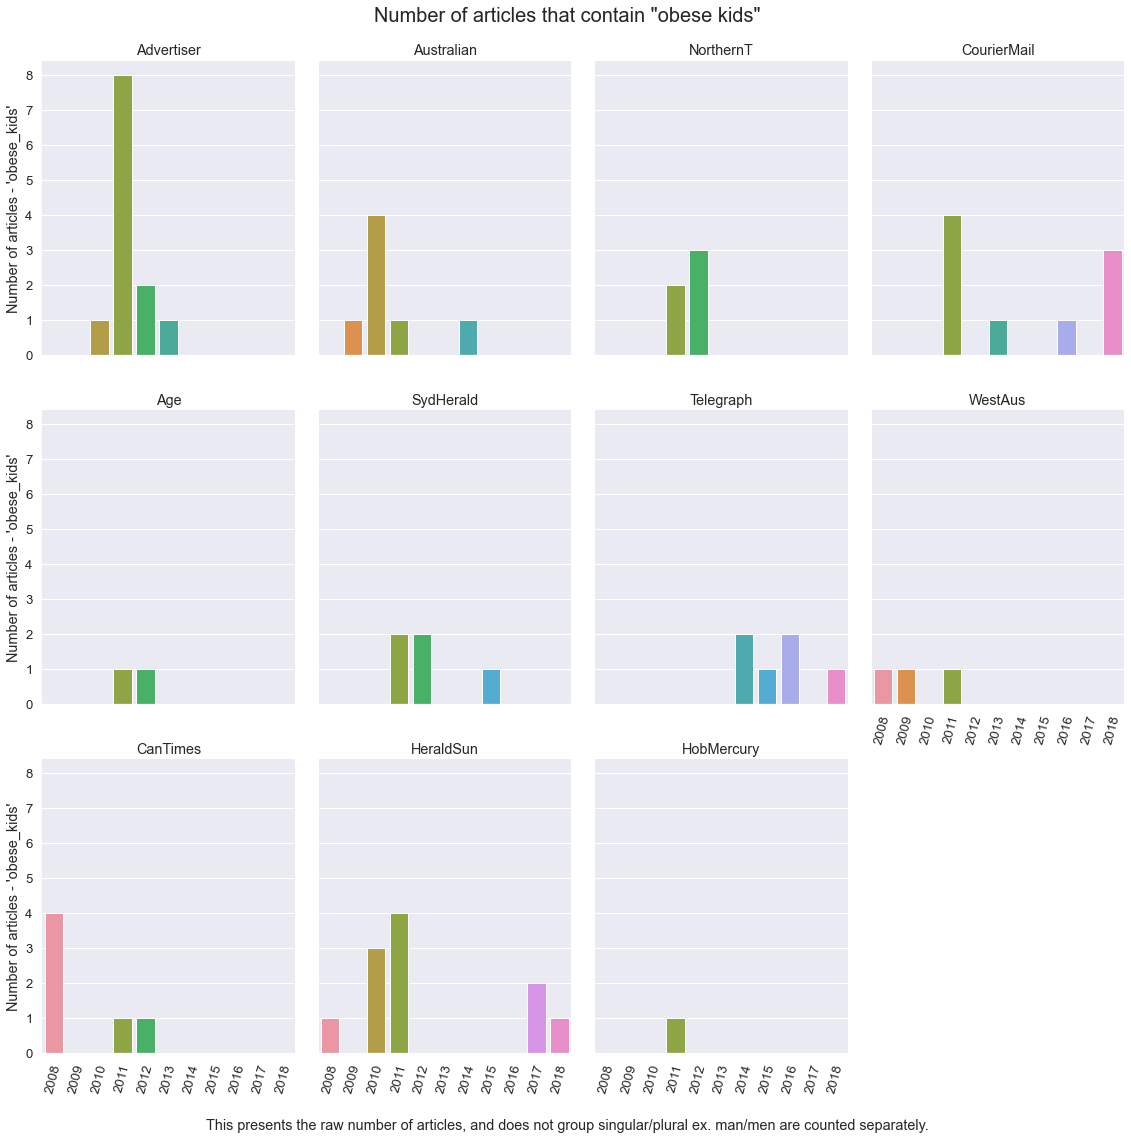

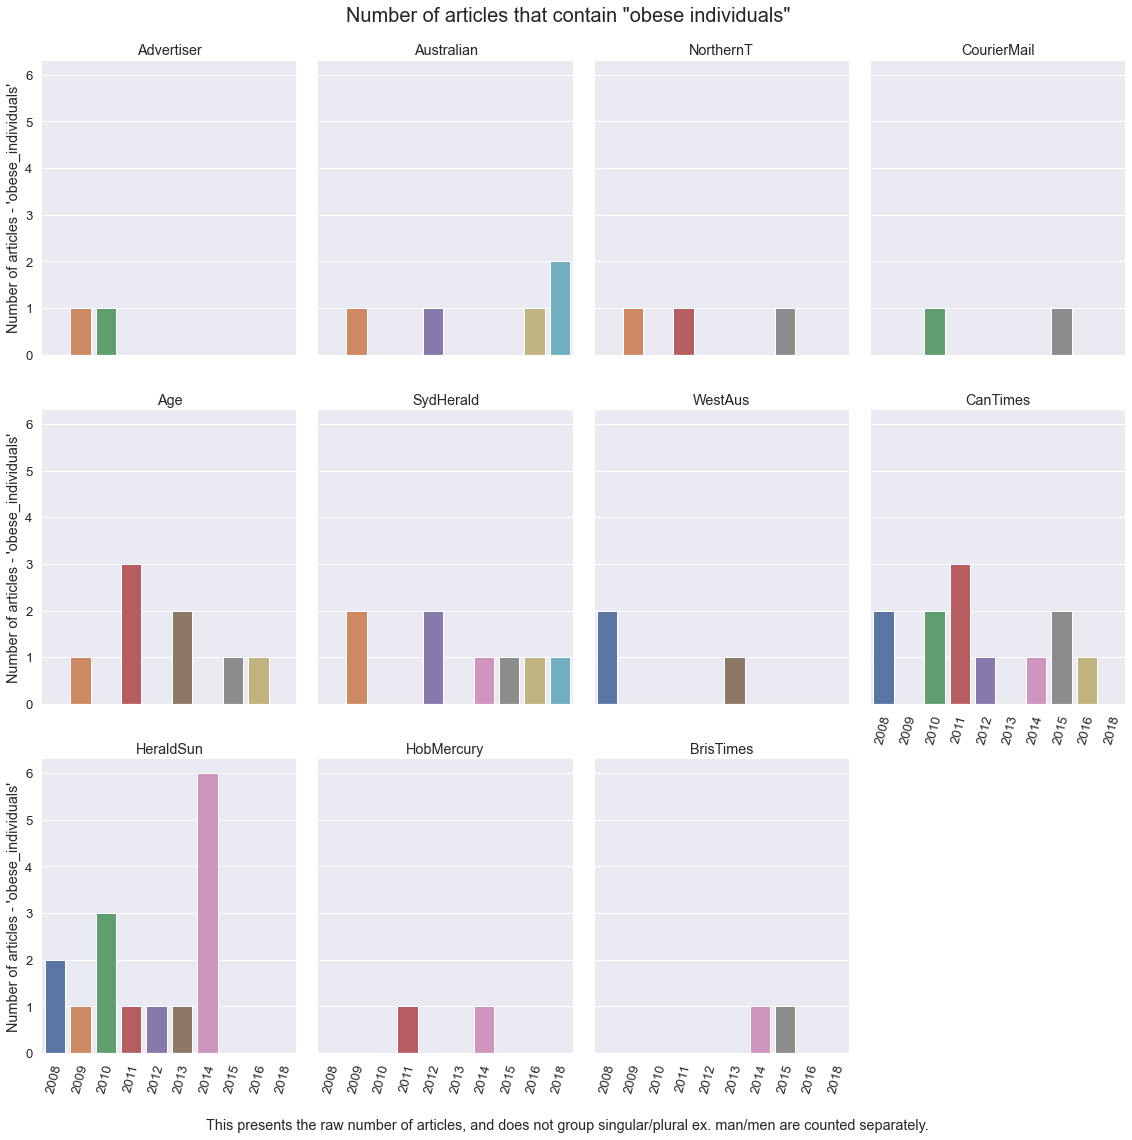

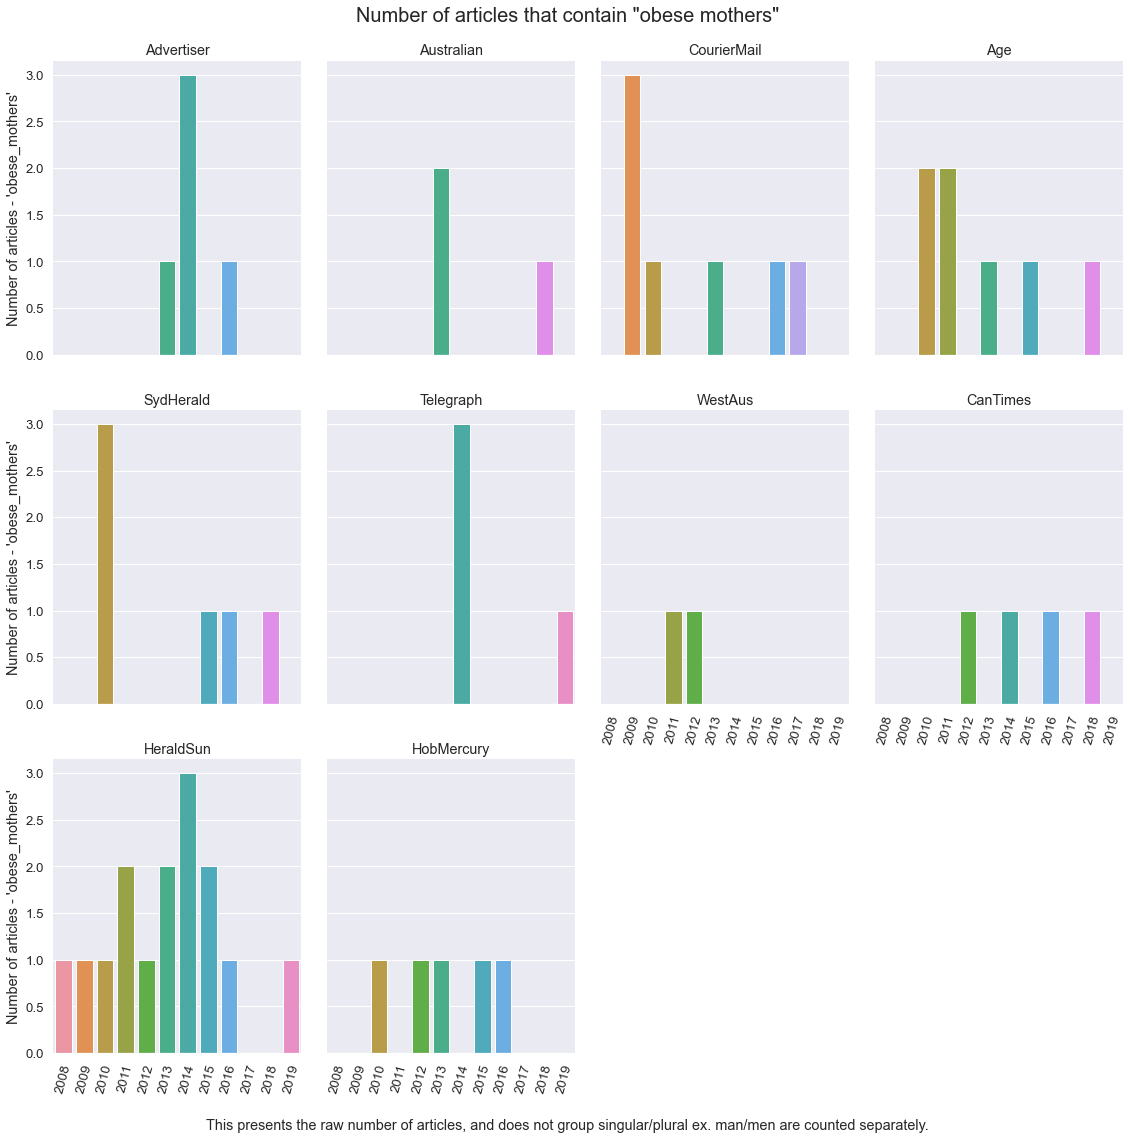

In [45]:
# generate this plot for the 15 most frequent pairings
for x in obese_amod.headword.value_counts().head(15).index.values.tolist():
    wordplot(x, df = obese_amod, type = 'headword', folder="obese_amod_head",
             filename = f"obese_{x}",
             title=f'Number of articles that contain "obese {x}"',
             caption="This presents the raw number of articles, and does not group singular/plural ex. man/men are counted separately.")

